In [43]:
# Importing Relevant Packages
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
import random
import re
import csv
import unicodedata
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional
from statistics import stdev
from fpdf import FPDF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.optimize import minimize

In [11]:
# Forming the Data Structures
@dataclass
class Patient: # Forming the structure for the patients dataset
    id: int # Unique patient identifier
    name: str # Anonymised patient label
    age: int # Age of patient in yyears
    gender: str # Gender of patient
    admission_day: int # Day the patient was admitted in the hospital
    release_day: int # Day the patient was released from the hospital
    prefered_capacity: int # How many number of beds it is preffered the room to have
    specialism_id1: int # ID of the first required specialism 
    specialism_days_1: int # Number of days a patient requires the first specialism 
    specialism_id2: Optional[int] # ID of the second required specialism (not always there)
    specialism_days_2: Optional[int] # Number of days a patient requires the second specialism (not always there)
    needs: List[int] # ID of features the patient needs       
    prefers: List[int]  # ID of features the patient prefers


@dataclass
class Room: # Forming the structure for the room dataset
    id: int # Unique room identifier
    room_number: int  # Room number in hospital
    department: int # ID of the department the room belongs
    capacity: int # How many beds the room has
    gender: str # Gender the room is designated for
    has: List[int]  # Equipment the room has           
    spec_ids: List[int]  # IDs of the specialisms supported by this room       
    penalties: List[int] # Penalties of specialisms

In [7]:
def build_hospital_data(): # Constructing Room and Patient objects based on the structures created
    rooms_df = pd.read_csv("cleaned_rooms9.csv") # Load cleaned room CSV 
    patients_df = pd.read_csv("cleaned_patients9.csv") # Load cleaned patients CSV

    # Constructing Room objects based on the structures created
    rooms = []
    for i, row in rooms_df.iterrows():
        equipment = [] # Collecting equipment fields dynamically
        for col in ["Telemetry", "Oxygen", "Nitrogen", "Television"]:
            if col in row and not pd.isna(row[col]):
                equipment.append(int(row[col]))

        room = Room( # Creating Room instances with the following fields
            id=i,
            room_number=int(row["RoomNumber"]),
            department=int(row["DepartmentID"]),
            capacity=int(row["Capacity"]),
            gender=row["Gender"],
            has=equipment,
            spec_ids=[
                int(row["ReqSpecialism1"]),
                int(row["ReqSpecialism2"]),
                int(row["ReqSpecialism3"])
            ],
            penalties=[
                int(row["PenaltySpecialism1"]),
                int(row["PenaltySpecialism2"]),
                int(row["PenaltySpecialism3"])
            ]
        )
        rooms.append(room)

    # Constructing Patient objects based on the structures created
    patients = []
    for i, row in patients_df.iterrows():
        needs = [] # Collecting needed equipment fields dynamically
        for col in ["NeedsTelemetry", "NeedsOxygen", "NeedsNitrogen", "NeedsTV"]:
            if col in row and not pd.isna(row[col]):
                needs.append(int(row[col]))

        prefers = [] # Collecting preffered equipment fields dynamically
        for col in ["PrefersTelemetry", "PrefersOxygen", "PrefersNitrogen", "PrefersTV"]:
            if col in row and not pd.isna(row[col]):
                prefers.append(int(row[col]))

        patient = Patient( # Creating Patient instances with the following fields
            id=i,
            name=row["Name"],
            age=int(row["Age"]),
            gender=row["Gender"],
            admission_day=int(row["AdmissionDay"]),
            release_day=int(row["ReleaseDay"]),
            prefered_capacity=int(row["PreferredRoomCapacity"]),
            specialism_id1=int(row["SpecialismID1"]) if not pd.isna(row["SpecialismID1"]) else None,
            specialism_days_1=int(row["SpecialismDays1"]) if not pd.isna(row["SpecialismDays1"]) else None,
            specialism_id2=int(row["SpecialismID2"]) if not pd.isna(row["SpecialismID2"]) else None,
            specialism_days_2=int(row["SpecialismDays2"]) if not pd.isna(row["SpecialismDays2"]) else None,
            needs=needs,
            prefers=prefers
        )
        patients.append(patient)

    return rooms, patients # Returns a tuple with two lists: one list for patient attributes and the other for room attributes


In [9]:
# Gini Coefficient is computed
def compute_gini(x):
    x = np.array(x) # Array with non-negative values
    if np.all(x == 0):  # If everyone has zero, then it is perfect equitablity
        return 0.0
    diff_sum = np.sum(np.abs(np.subtract.outer(x, x))) # Or else pairwise normalised absolute differences are computed
    return diff_sum / (2 * len(x) * np.sum(x))

# Jain's Index is computed
def compute_jain(x):
    x = np.array(x) # Array with non-negative values
    if np.sum(x) == 0: 
        return 1.0 # If everyone has zero, then it is perfect equitablity
    return (np.sum(x)**2) / (len(x) * np.sum(x**2)) # Or else this is returned

In [13]:
# Age limits for each department are extracted from the txt file
def parse_department_ages(filepath):
    department_age_limits = {}
    with open(filepath, 'r') as file: # All the lines of the file are read
        lines = file.readlines()
    dept_section_found = False
    for line in lines:
        line = line.strip()
        if line.startswith("DEPARTMENTS:"): # Look for the section starting with DEPARTMENTS
            dept_section_found = True
            continue

        if dept_section_found: 
            if not line or line.endswith(":"):  # Stop if a line or a new section is found: end of departmen section
                break

            parts = line.split()
            if len(parts) >= 4:
                try:
                    dept_id = int(parts[0]) # Fisrt is the ID of the department
                    # Second part is a label and in this case it is ignored
                    min_age = int(parts[2]) # Third is minimum age the department supports
                    max_age = int(parts[3]) # Fourth is maximum age the department supports
                    department_age_limits[dept_id] = (min_age, max_age)
                except ValueError:
                    continue  

    return department_age_limits # Returns a tuple of the age limits


In [15]:
# The penalty value of assigning a specific patient to a specific room
# Indicates how compatible is the allocation
def compatibility_penalty(p, r, department_age_limits=None):
    pen = 0 # Perfect compatibility

    # Violations that are added
    if r.capacity > p.prefered_capacity: # If room is larger than preferred
        pen += 3

    if r.gender in ['F', 'M'] and r.gender != p.gender: # If a room has a gender policy and accomodates a patient that is from a different gender
        pen += 5
        
    equip_len = min(len(p.prefers), len(r.has)) # If preferred equipment is missing
    if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
        pen += 3

    need_len = min(len(p.needs), len(r.has)) # If needed equipment is missing
    if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(need_len)):
        pen += 10

    if department_age_limits: # If there are deparment age limits and are violated
        min_age, max_age = department_age_limits.get(r.department, (0, 0))
        if (min_age and p.age < min_age) or (max_age and p.age > max_age):
            pen += 7

    # Specialisms Violations
    # Specialism 1 penalised according to each specialism's penalty is
    if p.specialism_id1 is not None:  
        if p.specialism_id1 in r.spec_ids:
            idx = r.spec_ids.index(p.specialism_id1)
            # if penalty_level == 1, no violations (as penalty is penalty_level-1)
            penalty_level = r.penalties[idx]
            if penalty_level == 2:
                pen += 2  # Minor
            elif penalty_level >= 3:
                pen += 4  # Major
        else:
            pen += 6  # Complete Mismatch

    # Specialism 2 penalised according to each specialism's penalty is
    if p.specialism_id2 is not None:
        if p.specialism_id2 in r.spec_ids:
            idx = r.spec_ids.index(p.specialism_id2)
            penalty_level = r.penalties[idx]
            # if penalty_level == 1, no violations (as penalty is penalty_level-1)
            if penalty_level == 2:
                pen += 2  # Minor
            elif penalty_level >= 3:
                pen += 4  # Major
        else:
            pen += 6  # Complete Mismatch

    return pen # Integer value of the penalty score

In [19]:
# Normalisation to ASCII for PDF compatibility
def clean_text(text):
    # Convert input to string if it's not already a string
    if not isinstance(text, str):
        text = str(text)
    # Normalize and encode/decode to remove non-ASCII characters
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")


# A stuctured report is generated including all the assignments over the planning horizon and patients and room characteristics
def generate_detailed_assignment_pdf(all_assignments, rooms, patients, benchmark_name="Benchmark", filename="hospital_assignment_report.pdf"):
    # Labels for different equipment types
    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']
    # Create lookup dictionaries for easy access to patient and room objects by their IDs
    patient_lookup = {p.id: p for p in patients}
    room_lookup = {r.id: r for r in rooms}

    # Define a custom PDF class inheriting from FPDF
    class PDF(FPDF):
        # Header method for the PDF, includes report title and benchmark name
        def header(self):
            self.set_font("Arial", "B", 14) # Set font for the header
            # Add the report title, centered
            self.cell(0, 10, clean_text(f"Hospital Room Assignment Report — {benchmark_name}"), ln=True, align="C")
            self.ln(5) # Add some space after the header

        # Method to add a title for each day in the report
        def day_title(self, day, num_patients):
            self.set_font("Arial", "B", 12) # Set font for the day title
            # Add the day title including the number of present patients
            self.cell(0, 10, clean_text(f"Day {day} — Present Patients: {num_patients}"), ln=True)
            self.ln(3) # Add space after the day title

        # Method to add a title and details for each room
        def room_title(self, room, patient_list):
            self.set_font("Arial", "B", 11) # Set font for the room title
            # Add the room details (ID, capacity, department, gender)
            self.cell(0, 8, clean_text(f"Room {room.id} (Capacity: {room.capacity}, Dept: {room.department}, Gender: {room.gender})"), ln=True)
            self.set_font("Arial", "", 10) # Set font for room details content

            # Check for missing equipment and print a message
            equipment_counts = {}
            # Iterate through patients in the room to check for equipment needs not met by the room
            for p in patient_list:
                for i in range(min(len(p.needs), len(room.has), len(equipment_labels))):
                    if p.needs[i] == 1 and room.has[i] == 0:
                        # Increment count for missing equipment type
                        equipment_counts[i] = equipment_counts.get(i, 0) + 1

            if equipment_counts: # Print missing equipment if any
                missing_str = "; ".join(f"{equipment_labels[i]} (needed by {count})" for i, count in equipment_counts.items())
                self.multi_cell(0, 7, clean_text(f"[MISSING] Equipment: {missing_str}")) # Add missing equipment details
            else: # Print if all equipment is there
                self.multi_cell(0, 7, "[OK] All required equipment covered for assigned patients.") # Indicate all equipment is present
            self.ln(2) # Add space after room details

        # Method to add a line for each patient with their details and penalty score
        def patient_line(self, p, r, penalty):
            self.set_font("Arial", "", 10) # Set font for patient details

            # Format patient specialisms
            specs = f"{p.specialism_id1}"
            if p.specialism_id2:
                specs += f", {p.specialism_id2}"

            # Identify patient preferences, needs, room equipment, and missing equipment
            equipment_pref = [equipment_labels[i] for i in range(min(len(p.prefers), len(equipment_labels))) if p.prefers[i] == 1]
            equipment_need = [equipment_labels[i] for i in range(min(len(p.needs), len(equipment_labels))) if p.needs[i] == 1]
            equipment_present = [equipment_labels[i] for i in range(min(len(r.has), len(equipment_labels))) if r.has[i] == 1]
            missing = [equipment_labels[i]
                       for i in range(min(len(p.needs), len(r.has), len(equipment_labels)))
                       if p.needs[i] == 1 and r.has[i] == 0]

            # Construct the patient details line
            line = (
                f"Patient {p.id} (Age: {p.age}, Gender: {p.gender}, Specs: {specs}, "
                f"Pref: {', '.join(equipment_pref) or 'None'}, "
                f"Needs: {', '.join(equipment_need) or 'None'}, "
                f"RoomEq: {', '.join(equipment_present) or 'None'}, "
                f"Missing: {', '.join(missing) or 'None'}, "
                f"Penalty: {penalty:.2f})"
            )
            self.multi_cell(0, 7, clean_text(line)) # Add the patient details line
            self.ln(1) # Add space after patient line

    # Create a PDF object
    pdf = PDF()
    # Enable automatic page breaks with a margin
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page() # Add the first page

    # Iterate through each day's assignments
    for day, data in all_assignments.items():
        assignments = data['assignments'] # Get assignments for the day
        scores = {v['patient_id']: v['total_score'] for v in data['violation_scores']} # Get violation scores
        patient_ids = list(assignments.keys()) # Get patient IDs for the day
        present = [patient_lookup[pid] for pid in patient_ids] # Get patient objects

        # Group patients by room
        room_groups = {}
        for pid, rid in assignments.items():
            room_groups.setdefault(rid, []).append(patient_lookup[pid]) # Group patients by room ID

        pdf.day_title(day, len(present)) # Add day title to the PDF

        # Iterate through rooms and add room and patient details to the PDF
        for rid, patient_list in sorted(room_groups.items()):
            r = room_lookup[rid] # Get room object
            pdf.room_title(r, patient_list) # Add room title to the PDF
            for p in patient_list:
                score = scores.get(p.id, 0) # Get penalty score for the patient
                pdf.patient_line(p, r, score) # Add patient details to the PDF

    # Save the generated PDF file
    pdf.output(filename, 'F')

Solving day 0...
Day 0 (initial) thresholds - Low: 7.00, High: 16.00
Day 0 solved in 0.63s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 8.00, High: 17.00
Day 1 solved in 1.32s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 9.00, High: 19.00
Day 2 solved in 1.84s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 9.00, High: 19.50
Day 3 solved in 3.75s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 11.00, High: 22.40
Day 4 solved in 4.56s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 13.00, High: 28.50
Day 5 solved in 4.45s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 13.00, High: 31.57
Day 6 solved in 3.21s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 12.25, High: 26.25
Day 7 solved in 4.81s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 12.00, High: 23.33
Day 8 solved in 5.45s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 11.40, High: 22.40
Day 9 solved in 5.74s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 12.27, High: 23.27
Day 10 solve

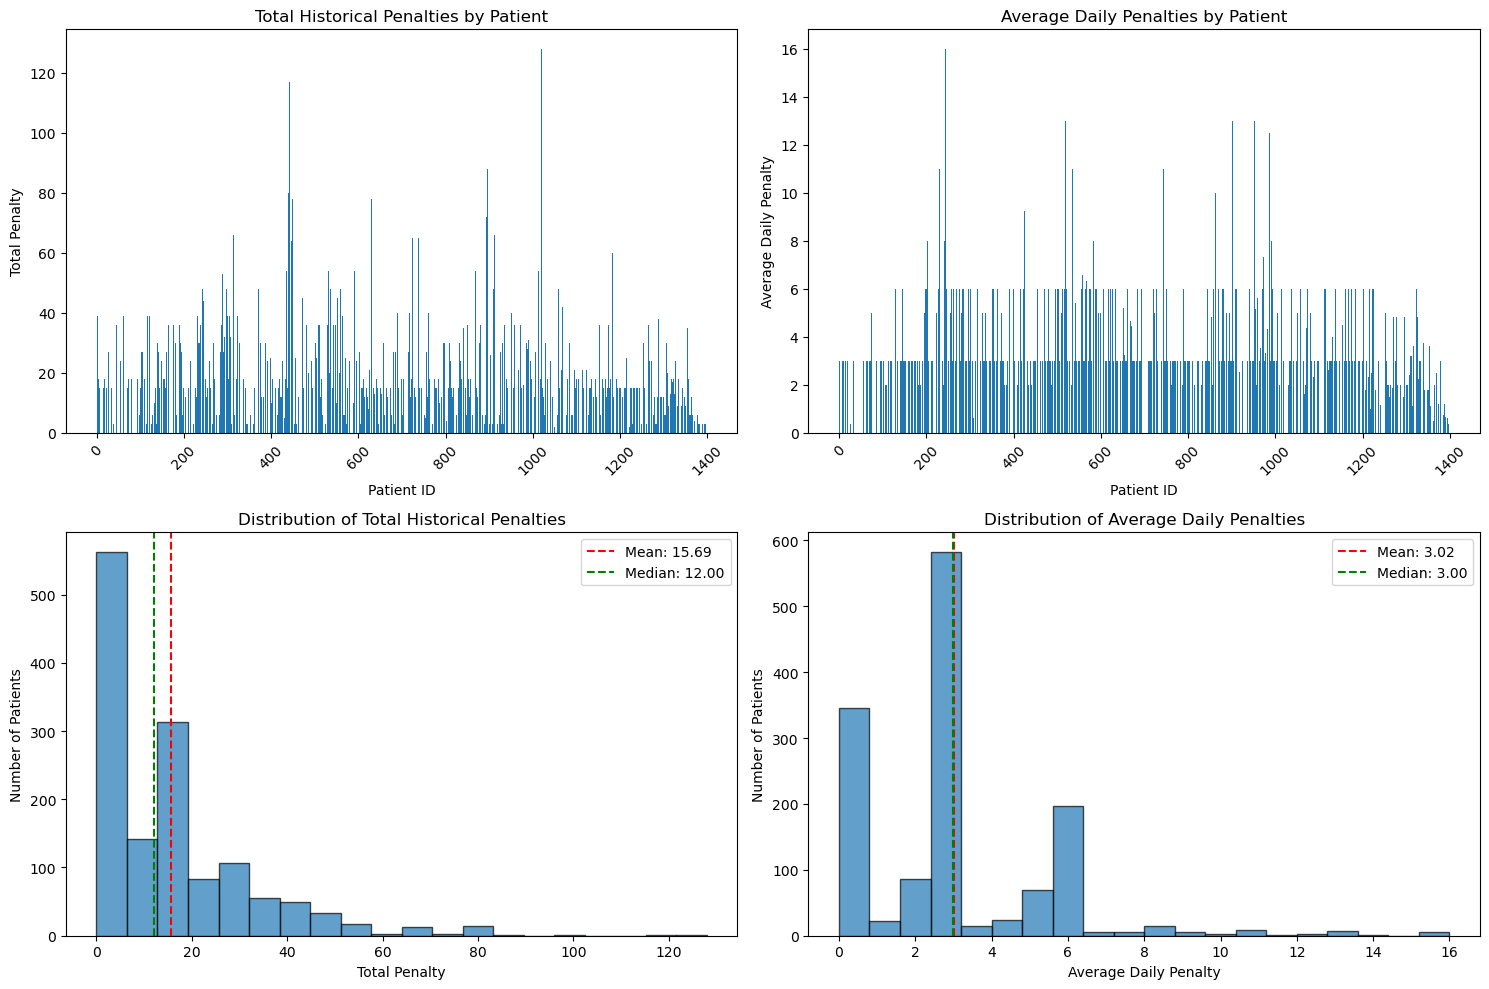

C:\Users\andri\AppData\Local\Temp\ipykernel_24016\2006095214.py:463: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot


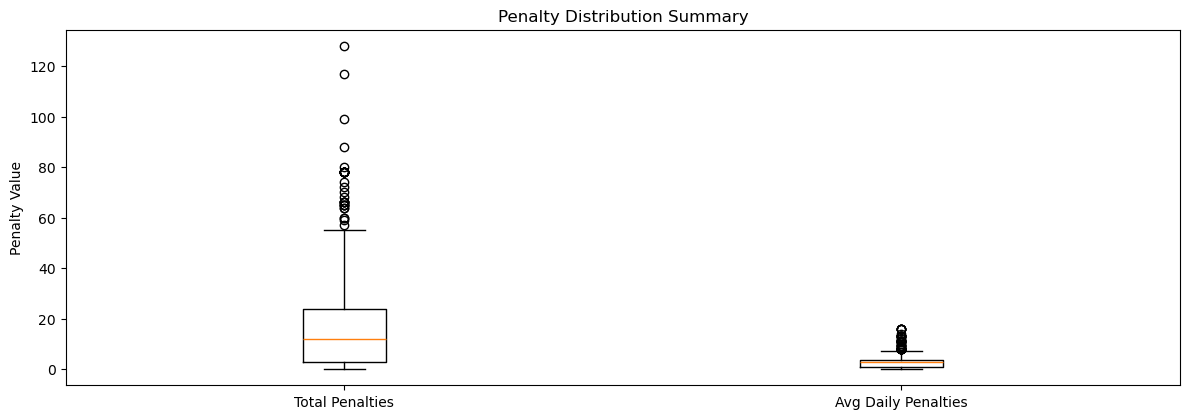

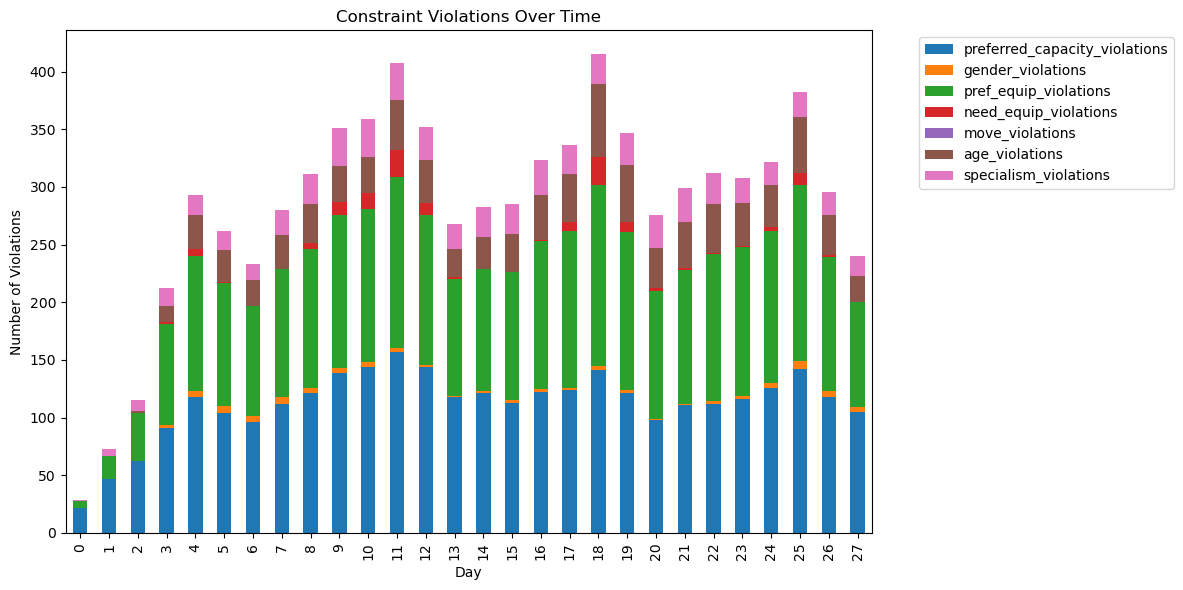

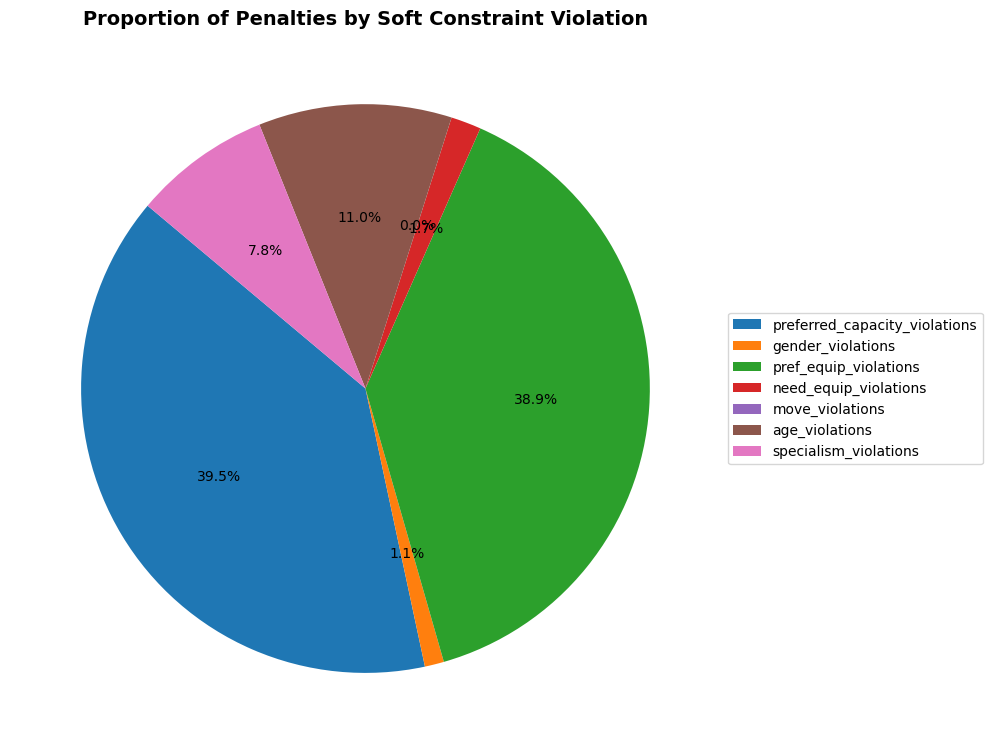

In [21]:
# Model 1 Basic Model
# Main function to solve the hospital allocation problem
def solve_hospital_allocation():
    # 1) Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data()
    random.seed(42) # Set random seed for reproducibility
    # Parse age limits for each department from a file
    department_age_limits = parse_department_ages("test9.txt")

    # Metrics bookkeeping - Initialize variables to track performance and fairness
    total_duration = 0.0 # Total time taken to solve all days
    historical_penalties = {p.id: 0 for p in patients} # Dictionary to store cumulative penalties for each patient
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for the current day's assignments

    # 2) Horizon: days 0 … last admission day - Determine the range of days to consider
    last_admission_day = max(p.admission_day for p in patients) # Find the latest admission day among all patients
    all_days = range(last_admission_day + 1) # Create a range of all days from 0 up to the last admission day
    logs = {} # Dictionary for logging information (currently not used)
    all_assignments = {} # Dictionary to store assignment results for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation - Iterate through each day
    for current_day in all_days:
        print(f"Solving day {current_day}...") # Print the current day being solved
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Get penalties from the previous day
        max_prev_penalty = max(prev_penalties.values(), default=None) # Find the maximum penalty from the previous day

        # Identify patients present on the current day
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        if not present_patients: # If no patients are present, skip to the next day
            continue

        # Calculate fairness thresholds based on historical penalties or base penalties
        if current_day > 0:
            # For days after the first, calculate fairness scores considering historical penalties
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    # Calculate base penalty and apply bias based on historical penalty
                    base_pen = compatibility_penalty(p, r)
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1) # Avoid division by zero
                    fairness_score = base_pen * bias
                    all_fairness_scores.append(fairness_score)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else:
            # For the first day, calculate thresholds based on base penalties only
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r)
                    all_base_scores.append(base_pen)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_base_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # 3) CP-SAT Model Definition
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to store boolean variables representing patient-room assignments
        # Create a boolean variable for each possible patient-room assignment on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Constraints
        # Each patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment requirement constraint (Hard Constraint)
        # Determine the maximum number of equipment types to consider
        num_equipment_types = min(
            max(len(r.has) for r in rooms),
            max(len(p.needs) for p in present_patients)
        )

        # Enforce equipment need constraint for each equipment type
        for i in range(num_equipment_types):
            # Identify rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count of rooms with the equipment

            # Identify patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count of patients who need the equipment

            # Only enforce hard constraint if availability is greater than or equal to demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Ensure that a patient needing this equipment is assigned to a room that has it
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)


        # Soft Constraint Violations - Lists to store boolean variables for each type of violation
        viol_pref_cap = [] # Violations of preferred room capacity
        viol_gender = [] # Violations of gender preference
        viol_pref_eq = [] # Violations of preferred equipment
        viol_need_eq = [] # Violations of needed equipment (when not a hard constraint)
        viol_age = [] # Violations of department age limits
        viol_spec_minor = [] # Minor specialism mismatches (penalty 2)
        viol_spec_major = [] # Major specialism mismatches (penalty >= 3)
        viol_spec_mismatch = [] # Specialism not supported by the room
        move_penalties = [] # Penalties for moving a patient to a different room

        # Populate the violation lists based on potential assignments
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the patient's previous room assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # The boolean variable for this patient-room assignment

                # Check for each type of soft constraint violation if this assignment is made
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s)
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s)
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s)

                equip_need_len = min(len(p.needs), len(r.has))
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s)
                # --- Generalized Age Constraint --- Check age limits based on department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s)

                # --- Specialism 1 --- Check penalty for the first specialism
                if p.specialism_id1 in r.spec_ids:
                    idx = r.spec_ids.index(p.specialism_id1)
                    pen = r.penalties[idx]
                    if pen == 2:
                        viol_spec_minor.append(s)
                    elif pen >= 3:
                        viol_spec_major.append(s)
                else:
                    viol_spec_mismatch.append(s)

                # --- Specialism 2 --- Check penalty for the second specialism if it exists
                if p.specialism_id2 is not None:
                    if p.specialism_id2 in r.spec_ids:
                        idx = r.spec_ids.index(p.specialism_id2)
                        pen = r.penalties[idx]
                        if pen == 2:
                            viol_spec_minor.append(s)
                        elif pen >= 3:
                            viol_spec_major.append(s)
                    else:
                        viol_spec_mismatch.append(s)

                # --- Move Penalty --- Add penalty if the patient is moved to a different room
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s)

        # Total number of patient-seat pairs (for normalization) - Used to scale the objective function
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools - Helper function for scaling sums of boolean variables
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / normalizer)

        # Weights - Define weights for each type of soft constraint violation
        Wcap, Wgen, Wpeq, Wneq, Wage = 3, 5, 3, 10, 7
        Wspec_minor, Wspec_major, Wspec_mismatch = 2, 6, 8
        Wmove = 10

        # Minimize scaled and weighted sum - Define the objective function to minimize total weighted violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap)
            + Wgen * normalized_sum(viol_gender)
            + Wpeq * normalized_sum(viol_pref_eq)
            + Wneq * normalized_sum(viol_need_eq)
            + Wage * normalized_sum(viol_age)
            + Wspec_minor * normalized_sum(viol_spec_minor)
            + Wspec_major * normalized_sum(viol_spec_major)
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch)
            + Wmove * normalized_sum(move_penalties)
        )

        # 4) Solve the model for the current day
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the defined model
        day_duration = time.time() - start # Calculate the time taken to solve the day
        total_duration += day_duration # Add the day's duration to the total duration

        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}") # Print solving status and time

        # 5) Process results if a solution is found
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the assigned room for each patient
            violation_scores = [] # List to store detailed violation scores for each patient-assignment
            daily_score = 0 # Total penalty score for the current day

            # Iterate through present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true
                        assigned_room = r # Assign the room
                        assign[p.id] = r.id # Store the assignment
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient
                        break # Move to the next patient once the room is found

                # If a room was assigned, calculate its penalty and update historical penalties
                if assigned_room:
                    pen = compatibility_penalty(p, assigned_room) # Calculate the compatibility penalty
                    daily_score += pen # Add to the daily total score
                    historical_penalties[p.id] += pen  # Update cumulative historical penalties

                    # Example equipment labels (update this list to match your dataset's actual columns and order)
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']  # Ensure this matches the actual dataset

                    # Only consider the minimum length to avoid IndexError in cases of inconsistent data
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find missing equipment indices
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine effective lengths for equipment lists for violation checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations --- Count specialism violation types
                    spec_minor = 0
                    spec_major = 0
                    spec_mismatch = 0

                    # Specialism 1
                    if p.specialism_id1 in assigned_room.spec_ids:
                        idx = assigned_room.spec_ids.index(p.specialism_id1)
                        spec_pen = assigned_room.penalties[idx]
                        if spec_pen == 2:
                            spec_minor += 1
                        elif spec_pen >= 3:
                            spec_major += 1
                    else:
                        spec_mismatch += 1

                    # Specialism 2
                    if p.specialism_id2 is not None:
                        if p.specialism_id2 in assigned_room.spec_ids:
                            idx = assigned_room.spec_ids.index(p.specialism_id2)
                            spec_pen = assigned_room.penalties[idx]
                            if spec_pen == 2:
                                spec_minor += 1
                            elif spec_pen >= 3:
                                spec_major += 1
                        else:
                            spec_mismatch += 1

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen,
                        'historical_penalty': historical_penalties[p.id],
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if needed equipment is missing (and not a hard constraint violation), 0 otherwise
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)),  # 1 if age limit violated, 0 otherwise (Update if using dynamic department age limits)
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatches
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id)) # 1 if patient was moved, 0 otherwise
                        }
                    })

                # Save results for the current day
                all_assignments[current_day] = {
                    'assignments': assign, # Assigned room for each patient
                    'violation_scores': violation_scores # Detailed violation scores
                }

                # Violation Counters (dynamic for equipment length)
                move_count = sum(v['violations']['moved'] for v in violation_scores) # Count of patients who were moved


            # Store the assignments and violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of patients present
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores), # Total preferred capacity violations
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores), # Total gender violations
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores), # Total preferred equipment violations
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores), # Total needed equipment violations
                'age_violations': sum(v['violations']['age'] for v in violation_scores), # Total age violations
                'specialism_violations': sum( # Total specialism violations (sum of minor, major, mismatch)
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                'total_violation_score': daily_score, # Total daily penalty score
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # 6) Final metrics and reporting - Calculate overall statistics and generate reports
    if results: # Proceed only if there are results
        df = pd.DataFrame(results) # Convert results list to a pandas DataFrame
        total_days = len(all_days) # Total number of days in the planning horizon
        success_rate = len(results) / total_days * 100 # Percentage of days successfully solved
        patient_ids = list(historical_penalties.keys()) # List of all patient IDs
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        penalty_vals = list(avg_daily_penalty.values()) # List of average daily penalty values

        # Calculate fairness metrics (Standard Deviation, Gini, Jain)
        std_dev = np.std(penalty_vals)
        gini = compute_gini(penalty_vals)
        jain = compute_jain(penalty_vals)

        # Calculate average penalties for all patients and find min/max
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        max_penalty_idx = np.argmax(penalty_vals) # Index of patient with maximum average daily penalty
        min_penalty_idx = np.argmin(penalty_vals) # Index of patient with minimum average daily penalty

        # Build summary stats - Create a dictionary for the summary statistics table
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)",
                "Success Rate (%)",
                "Fairness - StdDev of Daily Penalty",
                "Fairness - Gini Coefficient",
                "Fairness - Jain Index",
                "Total Penalty - Mean",
                "Total Penalty - StdDev",
                "Total Penalty - Min",
                "Total Penalty - Max",
                "Avg Daily Penalty - Mean",
                "Avg Daily Penalty - StdDev",
                "Avg Daily Penalty - Min",
                "Avg Daily Penalty - Max",
                "Patients with Zero Penalty",
                "Patients with High Penalty (>mean+std)",
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})",
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})",
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total solving time
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of patients with high penalty
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Details for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Details for least penalized patient
            ]
        }

        # Create a DataFrame for the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False))
        # Save summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics9.csv", index=False)
        # Save summary statistics as a PNG image (table format)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        table = ax.table(cellText=summary_df.values, # Create table from DataFrame values
                         colLabels=summary_df.columns, # Use DataFrame columns as column labels
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table in the axes
        table.auto_set_font_size(False) # Disable automatic font sizing
        table.set_fontsize(10) # Set font size for table text
        table.scale(1, 1.2) # Scale the table size
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Add a title
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig("hospital_summary_statistics9.png", dpi=300) # Save the table as a PNG image
        plt.close() # Close the plot

        # Plots - Generate various plots to visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots

        # 1. Total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar chart
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-axis label
        axes[0,0].set_ylabel('Total Penalty') # Set y-axis label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

        # 2. Average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar chart
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-axis label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-axis label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-axis label
        axes[1,0].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-axis label
        axes[1,1].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary9.png") # Save the subplots as a PNG image
        plt.show() # Display the plots

        # Additional detailed penalty analysis
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing penalty distribution
        plt.subplot(2, 1, 1) # Create a subplot (2 rows, 1 column, 1st plot)
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-axis label

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary9.png") # Save the box plot as a PNG image
        plt.show() # Display the plot

        # Constraint Violations Over Time (Stacked Bar Chart)
        violation_cols = [ # List of columns representing different violation types
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations'
        ]

        # Plot stacked bar chart of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Number of Violations") # Set y-axis label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time3.png") # Save the plot as a PNG image
        plt.show() # Display the plot

        # Proportion of Penalties by Soft Constraint Violation (Pie Chart)
        # Sum total violations for each type
        violation_totals = df[violation_cols].sum() # Calculate the sum of each violation type across all days

        plt.figure(figsize=(10, 10)) # Create a new figure
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels directly on slices
            autopct='%1.1f%%', # Format for percentage display
            startangle=140 # Starting angle for the first slice
        )
        # Add a legend with violation types and percentages
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold') # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart9.png", dpi=300) # Save the pie chart as a PNG image
        plt.show() # Display the plot

    # Return the results
    return all_assignments, rooms, patients, results

# Main execution block
if __name__ == "__main__":
    # Solve the hospital allocation problem
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark
        filename="hospital_assignment_report9.pdf" # Output filename for the PDF
    )

Solving day 0...
Day 0 (initial) thresholds - Low: 7.00, High: 16.00
Day 0 solved in 0.53s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 8.00, High: 17.00
Day 1 solved in 1.30s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 9.00, High: 18.00
Day 2 solved in 1.82s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 9.00, High: 19.00
Day 3 solved in 3.51s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 11.00, High: 22.00
Day 4 solved in 4.50s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 13.00, High: 27.00
Day 5 solved in 3.65s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 13.00, High: 29.71
Day 6 solved in 3.42s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 12.00, High: 24.75
Day 7 solved in 5.02s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 12.00, High: 23.33
Day 8 solved in 5.86s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 11.50, High: 22.00
Day 9 solved in 5.82s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 12.00, High: 22.91
Day 10 solve

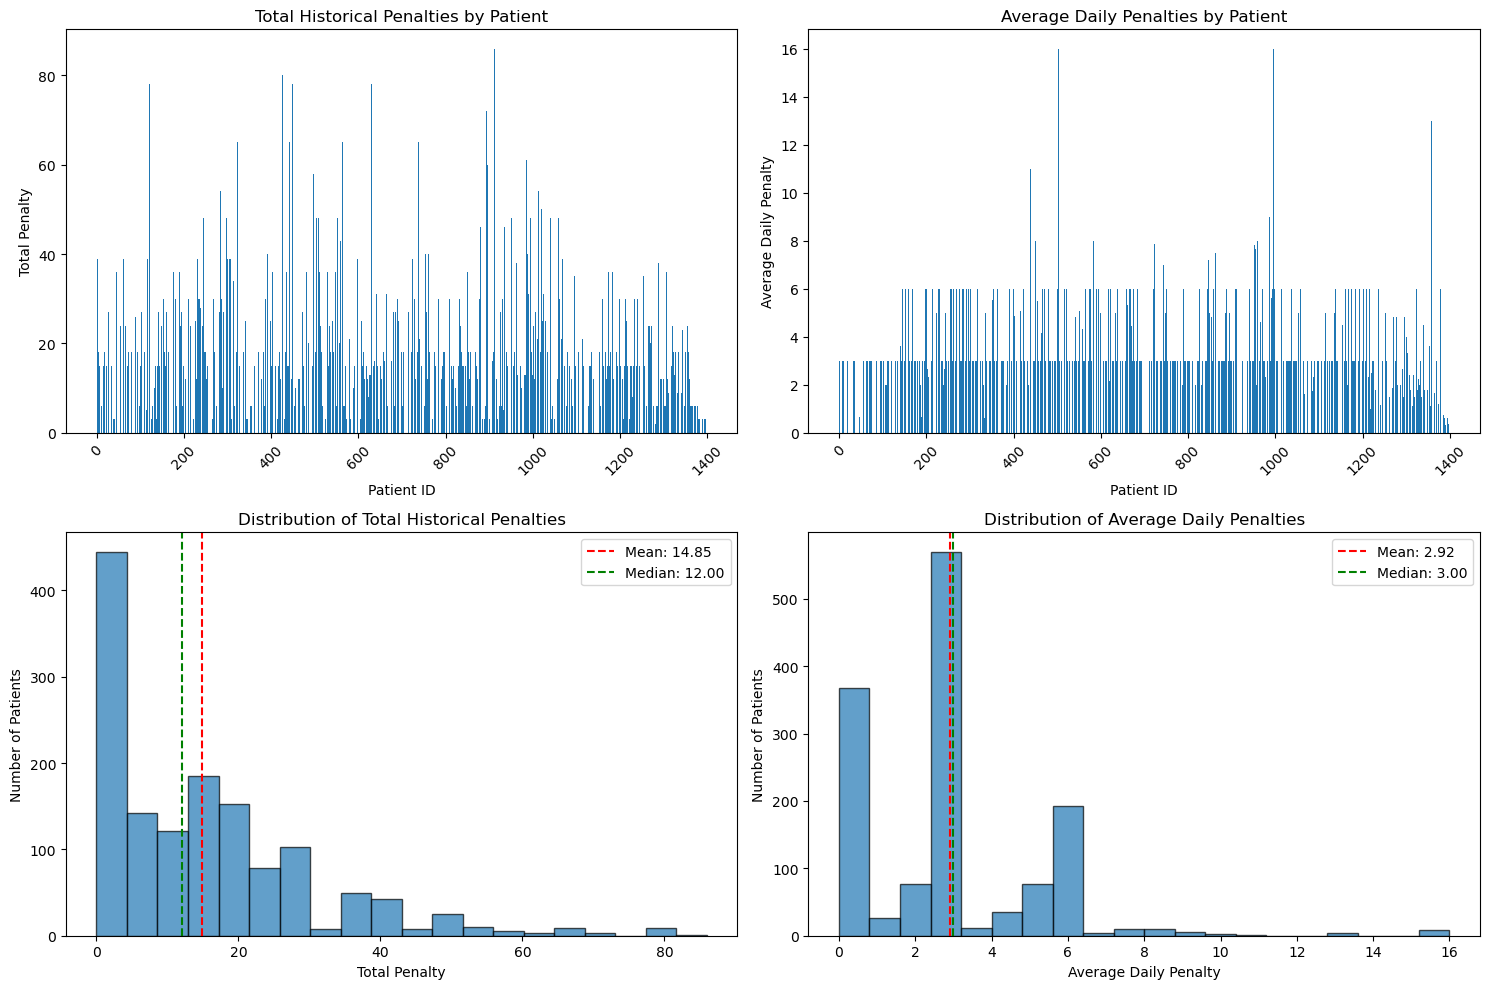

C:\Users\andri\AppData\Local\Temp\ipykernel_24016\1929428947.py:490: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot


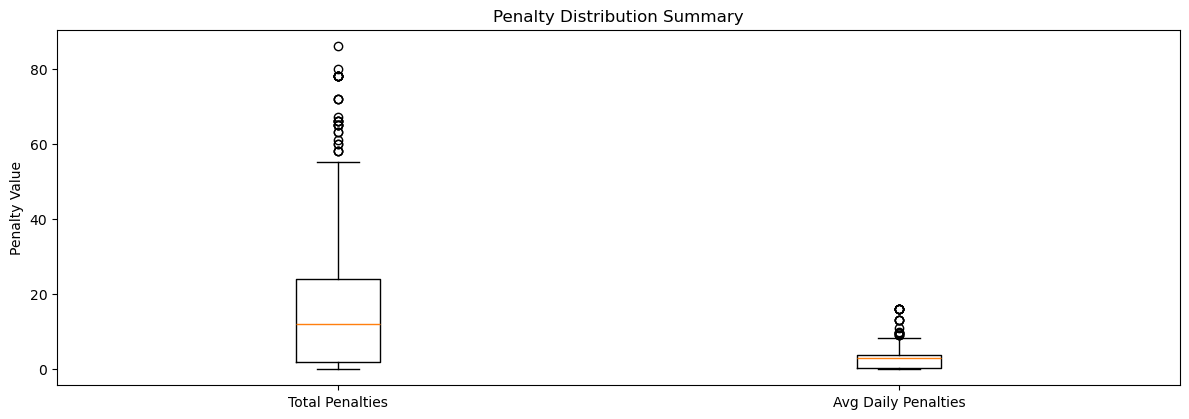

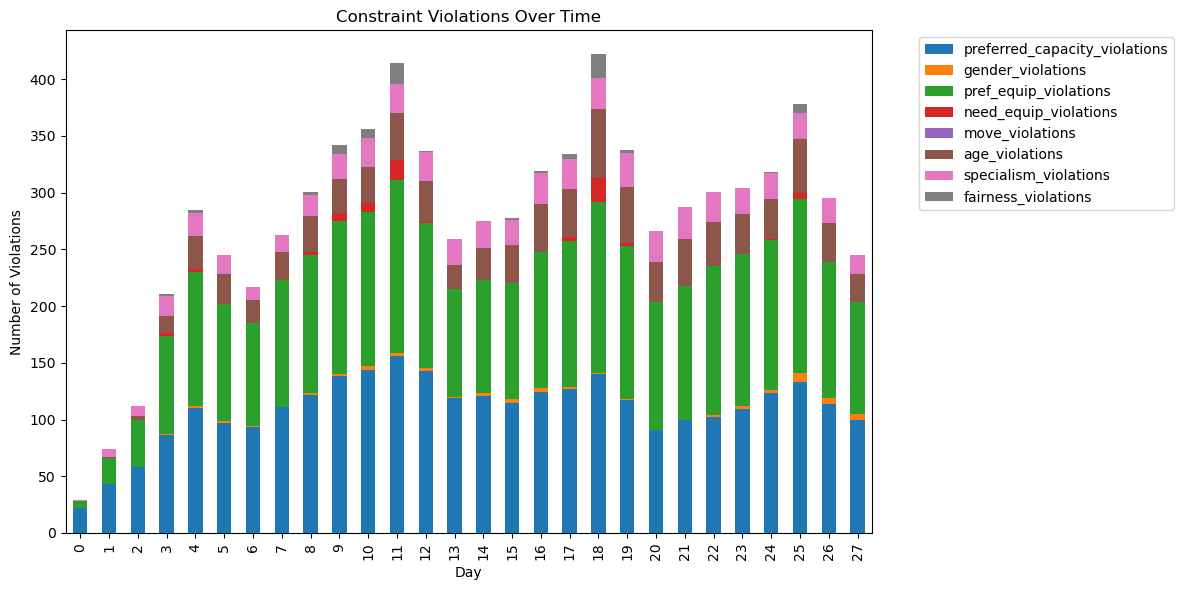

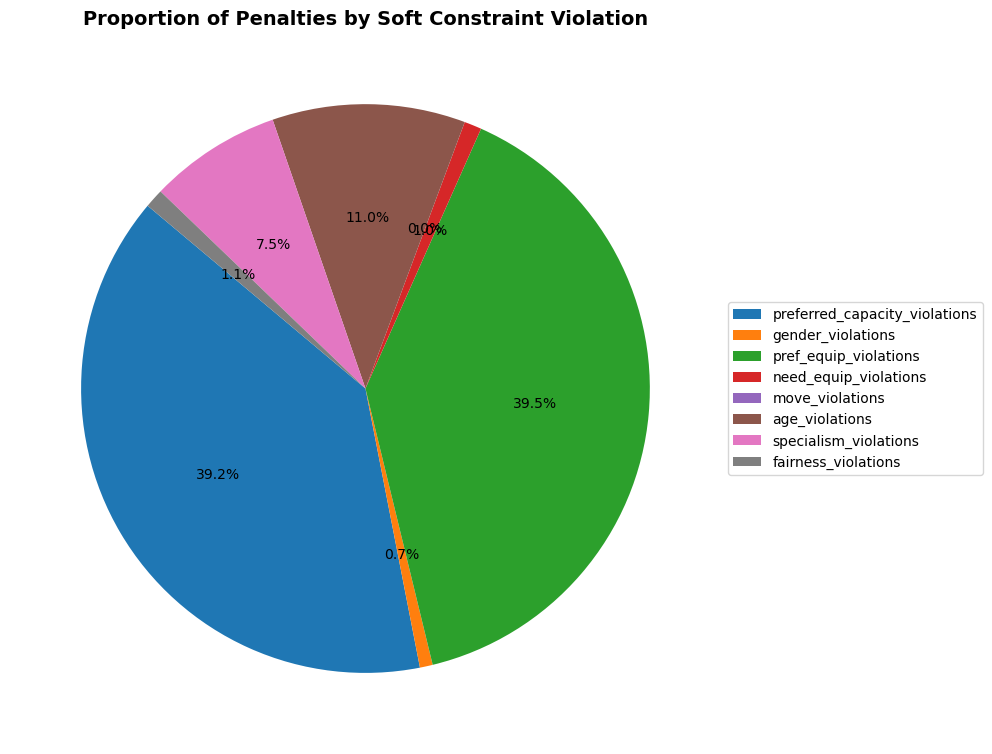

In [23]:
# Model 2 Historical Bias 
# Main function to solve the hospital allocation problem
def solve_hospital_allocation():
    # 1) Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data() # Loads room and patient data
    random.seed(42) # Set random seed for reproducibility
    # Parse age limits for each department from a file
    department_age_limits = parse_department_ages("test9.txt") # Parses age constraints from a file

    # Metrics bookkeeping - Initialize variables to track performance and fairness
    total_duration = 0.0 # Total time taken to solve all days
    historical_penalties = {p.id: 0 for p in patients} # Dictionary to store cumulative penalties for each patient
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for the current day's assignments

    # 2) Horizon: days 0 … last admission day - Determine the range of days to consider
    last_admission_day = max(p.admission_day for p in patients) # Find the latest admission day among all patients
    all_days = range(last_admission_day + 1) # Create a range of all days from 0 up to the last admission day
    logs = {} # Dictionary for logging information (currently not used)
    all_assignments = {} # Dictionary to store assignment results for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation - Iterate through each day
    for current_day in all_days:
        print(f"Solving day {current_day}...") # Print the current day being solved
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Get penalties from the previous day
        max_prev_penalty = max(prev_penalties.values(), default=None) # Find the maximum penalty from the previous day

        # Identify patients present on the current day
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        if not present_patients: # If no patients are present, skip to the next day
            continue

        # Calculate fairness thresholds based on historical penalties or base penalties
        if current_day > 0:
            # For days after the first, calculate fairness scores considering historical penalties
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    # Calculate base penalty and apply bias based on historical penalty
                    base_pen = compatibility_penalty(p, r)
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1) # Avoid division by zero
                    fairness_score = base_pen * bias
                    all_fairness_scores.append(fairness_score)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else:
            # For the first day, calculate thresholds based on base penalties only
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r)
                    all_base_scores.append(base_pen)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_base_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # 3) CP-SAT Model Definition
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to store boolean variables representing patient-room assignments
        # Create a boolean variable for each possible patient-room assignment on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Constraints
        # Each patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment requirement constraint (Hard Constraint)
        # Determine the maximum number of equipment types to consider
        num_equipment_types = min(
            max(len(r.has) for r in rooms),
            max(len(p.needs) for p in present_patients)
        )

        # Enforce equipment need constraint for each equipment type
        for i in range(num_equipment_types):
            # Identify rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count of rooms with the equipment

            # Identify patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count of patients who need the equipment

            # Only enforce hard constraint if availability is greater than or equal to demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Ensure that a patient needing this equipment is assigned to a room that has it
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)


        # Soft Constraint Violations - Lists to store boolean variables for each type of violation
        viol_pref_cap = [] # Violations of preferred room capacity
        viol_gender = [] # Violations of gender preference
        viol_pref_eq = [] # Violations of preferred equipment
        viol_need_eq = [] # Violations of needed equipment (when not a hard constraint)
        viol_age = [] # Violations of department age limits
        viol_spec_minor = [] # Minor specialism mismatches (penalty 2)
        viol_spec_major = [] # Major specialism mismatches (penalty >= 3)
        viol_spec_mismatch = [] # Specialism not supported by the room
        viol_fairness_low = [] # Fairness violations below the low threshold
        viol_fairness_medium = [] # Fairness violations between low and high thresholds
        viol_fairness_high = [] # Fairness violations above the high threshold
        move_penalties = [] # Penalties for moving a patient to a different room


        # Populate the violation lists based on potential assignments
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the patient's previous room assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # The boolean variable for this patient-room assignment

                # Check for each type of soft constraint violation if this assignment is made
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s)
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s)
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s)

                equip_need_len = min(len(p.needs), len(r.has))
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s)
                # --- Generalized Age Constraint --- Check age limits based on department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s)

                # --- Specialism 1 --- Check penalty for the first specialism
                if p.specialism_id1 in r.spec_ids:
                    idx = r.spec_ids.index(p.specialism_id1)
                    pen = r.penalties[idx]
                    if pen == 2:
                        viol_spec_minor.append(s)
                    elif pen >= 3:
                        viol_spec_major.append(s)
                else:
                    viol_spec_mismatch.append(s)

                # --- Specialism 2 --- Check penalty for the second specialism if it exists
                if p.specialism_id2 is not None:
                    if p.specialism_id2 in r.spec_ids:
                        idx = r.spec_ids.index(p.specialism_id2)
                        pen = r.penalties[idx]
                        if pen == 2:
                            viol_spec_minor.append(s)
                        elif pen >= 3:
                            viol_spec_major.append(s)
                    else:
                        viol_spec_mismatch.append(s)

                # Calculate fairness score with historical penalty bias
                base_pen = compatibility_penalty(p, r)
                if current_day > 0:
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias
                else:
                    fairness_score = base_pen

                # Check for fairness violations based on calculated thresholds
                if fairness_score > threshold_high:
                    viol_fairness_high.append(s)
                elif fairness_score > threshold_low:
                    viol_fairness_medium.append(s)
                elif fairness_score < threshold_low:
                    viol_fairness_low.append(s)
                # --- Move Penalty --- Add penalty if the patient is moved to a different room
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s)

        # Total number of patient-seat pairs (for normalization) - Used to scale the objective function
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools - Helper function for scaling sums of boolean variables
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / normalizer)

        # Weights - Define weights for each type of soft constraint violation
        Wcap, Wgen, Wpeq, Wneq, Wage = 3, 5, 3, 10, 7
        Wspec_minor, Wspec_major, Wspec_mismatch = 2, 6, 8
        Wfair_low, Wfair_med, Wfair_high = 1, 3, 9
        Wmove = 10

        # Minimize scaled and weighted sum - Define the objective function to minimize total weighted violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap)
            + Wgen * normalized_sum(viol_gender)
            + Wpeq * normalized_sum(viol_pref_eq)
            + Wneq * normalized_sum(viol_need_eq)
            + Wage * normalized_sum(viol_age)
            + Wspec_minor * normalized_sum(viol_spec_minor)
            + Wspec_major * normalized_sum(viol_spec_major)
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch)
            + Wfair_low * normalized_sum(viol_fairness_low)
            + Wfair_med * normalized_sum(viol_fairness_medium)
            + Wfair_high * normalized_sum(viol_fairness_high)
            + Wmove * normalized_sum(move_penalties)
        )

        # 4) Solve the model for the current day
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the defined model
        day_duration = time.time() - start # Calculate the time taken to solve the day
        total_duration += day_duration # Add the day's duration to the total duration

        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}") # Print solving status and time

        # 5) Process results if a solution is found
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the assigned room for each patient
            violation_scores = [] # List to store detailed violation scores for each patient-assignment
            daily_score = 0 # Total penalty score for the current day

            # Iterate through present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true
                        assigned_room = r # Assign the room
                        assign[p.id] = r.id # Store the assignment
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient
                        break # Move to the next patient once the room is found

                # If a room was assigned, calculate its penalty and update historical penalties
                if assigned_room:
                    pen = compatibility_penalty(p, assigned_room) # Calculate the compatibility penalty
                    daily_score += pen # Add to the daily total score
                    historical_penalties[p.id] += pen  # Update cumulative historical penalties

                    # Example equipment labels (update this list to match your dataset's actual columns and order)
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']  # Ensure this matches the actual dataset

                    # Only consider the minimum length to avoid IndexError in cases of inconsistent data
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find missing equipment indices
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine effective lengths for equipment lists for violation checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations --- Count specialism violation types
                    spec_minor = 0
                    spec_major = 0
                    spec_mismatch = 0

                    # Specialism 1
                    if p.specialism_id1 in assigned_room.spec_ids:
                        idx = assigned_room.spec_ids.index(p.specialism_id1)
                        spec_pen = assigned_room.penalties[idx]
                        if spec_pen == 2:
                            spec_minor += 1
                        elif spec_pen >= 3:
                            spec_major += 1
                    else:
                        spec_mismatch += 1

                    # Specialism 2
                    if p.specialism_id2 is not None:
                        if p.specialism_id2 in assigned_room.spec_ids:
                            idx = assigned_room.spec_ids.index(p.specialism_id2)
                            spec_pen = assigned_room.penalties[idx]
                            if spec_pen == 2:
                                spec_minor += 1
                            elif spec_pen >= 3:
                                spec_major += 1
                        else:
                            spec_mismatch += 1

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen,
                        'historical_penalty': historical_penalties[p.id],
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if needed equipment is missing (and not a hard constraint violation), 0 otherwise
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)),  # 1 if age limit violated, 0 otherwise (Update if using dynamic department age limits)
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatches
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id)) # 1 if patient was moved, 0 otherwise
                        }
                    })

                # Save results
                all_assignments[current_day] = {
                    'assignments': assign, # Assigned room for each patient
                    'violation_scores': violation_scores # Detailed violation scores
                }

                # Violation Counters (dynamic for equipment length)
                move_count = sum(v['violations']['moved'] for v in violation_scores) # Count of patients who were moved


            # Store the assignments and violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of patients present
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores), # Total preferred capacity violations
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores), # Total gender violations
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores), # Total preferred equipment violations
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores), # Total needed equipment violations
                'age_violations': sum(v['violations']['age'] for v in violation_scores), # Total age violations
                'specialism_violations': sum( # Total specialism violations (sum of minor, major, mismatch)
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                'fairness_violations': sum(1 for v in violation_scores if v['total_score']  > threshold_low), # Total fairness violations (total score > low threshold)
                'total_violation_score': daily_score, # Total daily penalty score
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # 6) Final metrics and reporting - Calculate overall statistics and generate reports
    if results: # Proceed only if there are results
        df = pd.DataFrame(results) # Convert results list to a pandas DataFrame
        total_days = len(all_days) # Total number of days in the planning horizon
        success_rate = len(results) / total_days * 100 # Percentage of days successfully solved
        patient_ids = list(historical_penalties.keys()) # List of all patient IDs
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        penalty_vals = list(avg_daily_penalty.values()) # List of average daily penalty values

        # Calculate fairness metrics (Standard Deviation, Gini, Jain)
        std_dev = np.std(penalty_vals)
        gini = compute_gini(penalty_vals)
        jain = compute_jain(penalty_vals)

        # Calculate average penalties for all patients and find min/max
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        max_penalty_idx = np.argmax(penalty_vals) # Index of patient with maximum average daily penalty
        min_penalty_idx = np.argmin(penalty_vals) # Index of patient with minimum average daily penalty

        total_fairness_penalties = df['fairness_violations'].sum() # Calculate the total fairness violations across all days
        print(f"Total Fairness Penalties: {total_fairness_penalties}") # Print total fairness penalties

        # Build summary stats - Create a dictionary for the summary statistics table
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)",
                "Success Rate (%)",
                "Fairness - StdDev of Daily Penalty",
                "Fairness - Gini Coefficient",
                "Fairness - Jain Index",
                "Total Penalty - Mean",
                "Total Penalty - StdDev",
                "Total Penalty - Min",
                "Total Penalty - Max",
                "Avg Daily Penalty - Mean",
                "Avg Daily Penalty - StdDev",
                "Avg Daily Penalty - Min",
                "Avg Daily Penalty - Max",
                "Patients with Zero Penalty",
                "Patients with High Penalty (>mean+std)",
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})",
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})",
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total solving time
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of patients with high penalty
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Details for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Details for least penalized patient
            ]
        }

        # Create a DataFrame for the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False))
        # Save summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics9.csv", index=False)
        # Save summary statistics as a PNG image (table format)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        table = ax.table(cellText=summary_df.values, # Create table from DataFrame values
                         colLabels=summary_df.columns, # Use DataFrame columns as column labels
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table in the axes
        table.auto_set_font_size(False) # Disable automatic font sizing
        table.set_fontsize(10) # Set font size for table text
        table.scale(1, 1.2) # Scale the table size
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Add a title
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig("hospital_summary_statistics9.png", dpi=300) # Save the table as a PNG image
        plt.close() # Close the plot

        # Plots - Generate various plots to visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots

        # 1. Total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar chart
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-axis label
        axes[0,0].set_ylabel('Total Penalty') # Set y-axis label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

        # 2. Average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar chart
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-axis label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-axis label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-axis label
        axes[1,0].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-axis label
        axes[1,1].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary9.png") # Save the subplots as a PNG image
        plt.show() # Display the plots

        # Additional detailed penalty analysis
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing penalty distribution
        plt.subplot(2, 1, 1) # Create a subplot (2 rows, 1 column, 1st plot)
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-axis label

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary9.png") # Save the box plot as a PNG image
        plt.show() # Display the plot

        # Constraint Violations Over Time (Stacked Bar Chart)
        violation_cols = [ # List of columns representing different violation types
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations', 'fairness_violations'
        ]

        # Plot stacked bar chart of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Number of Violations") # Set y-axis label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time9.png") # Save the plot as a PNG image
        plt.show() # Display the plot

        # Proportion of Penalties by Soft Constraint Violation (Pie Chart)
        # Sum total violations for each type
        violation_totals = df[violation_cols].sum() # Calculate the sum of each violation type across all days

        plt.figure(figsize=(10, 10)) # Create a new figure
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels directly on slices
            autopct='%1.1f%%', # Format for percentage display
            startangle=140 # Starting angle for the first slice
        )
        # Add a legend with violation types and percentages
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold') # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart9.png", dpi=300) # Save the pie chart as a PNG image
        plt.show() # Display the plot

    # Return the results
    return all_assignments, rooms, patients, results

# Main execution block
if __name__ == "__main__":
    # Solve the hospital allocation problem
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark
        filename="hospital_assignment_report9.pdf" # Output filename for the PDF
    )

Solving day 0...
Day 0 (initial) thresholds - Low: 7.00, High: 16.00
Day 0 solved in 0.56s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 8.00, High: 17.00
Day 1 solved in 1.33s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 9.00, High: 19.00
Day 2 solved in 1.94s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 9.00, High: 19.50
Day 3 solved in 3.63s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 11.00, High: 22.00
Day 4 solved in 4.66s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 13.00, High: 28.00
Day 5 solved in 3.82s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 13.29, High: 31.00
Day 6 solved in 3.38s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 12.50, High: 26.00
Day 7 solved in 5.25s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 12.00, High: 24.00
Day 8 solved in 5.73s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 11.70, High: 22.40
Day 9 solved in 5.96s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 12.27, High: 23.27
Day 10 solve

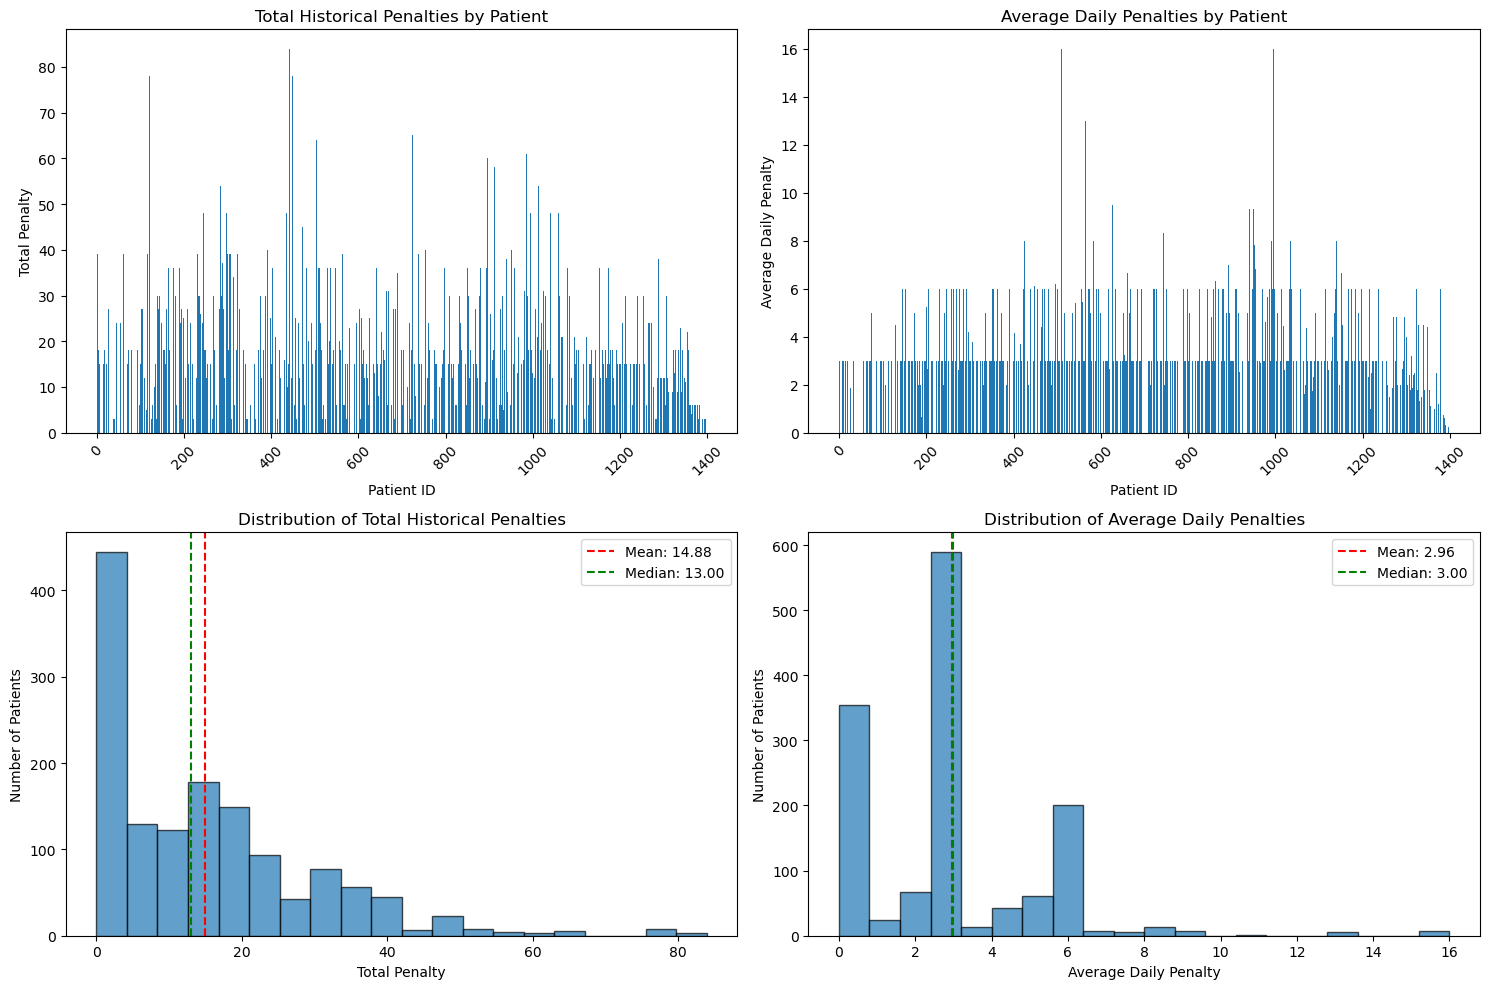

C:\Users\andri\AppData\Local\Temp\ipykernel_24016\3672628167.py:509: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot


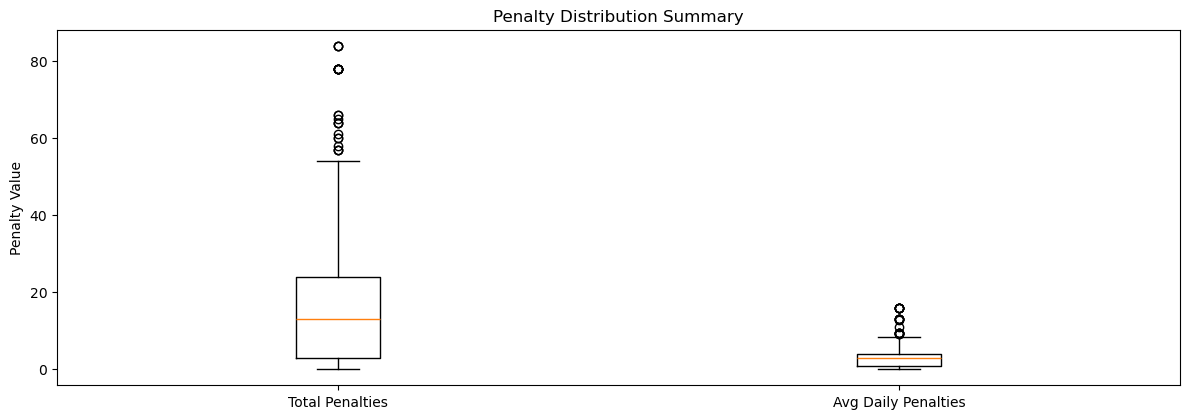

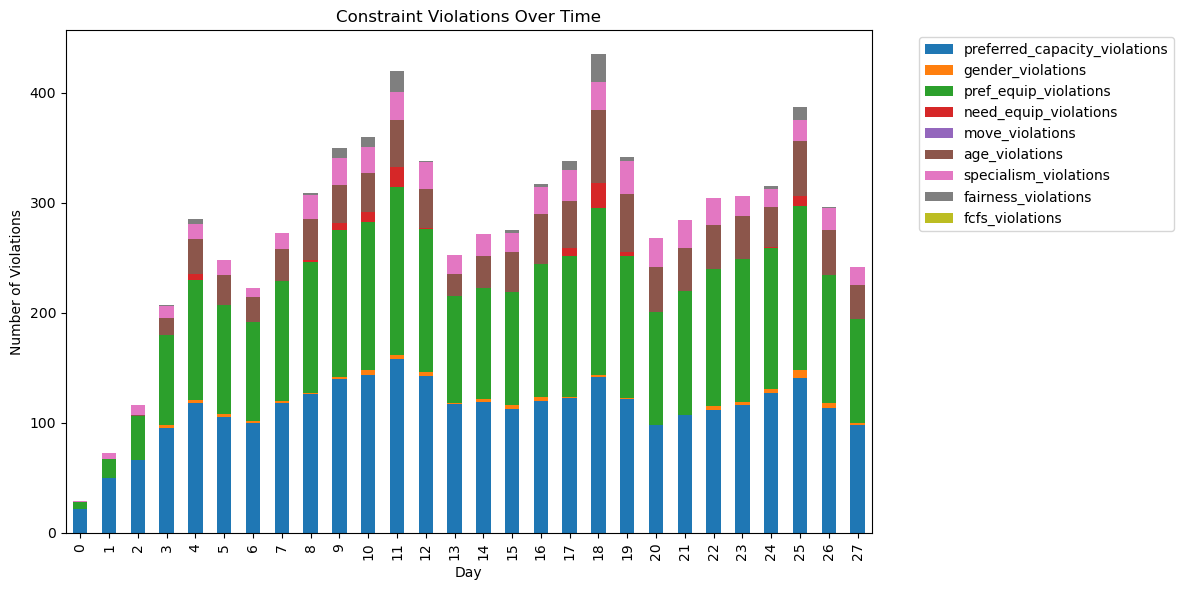

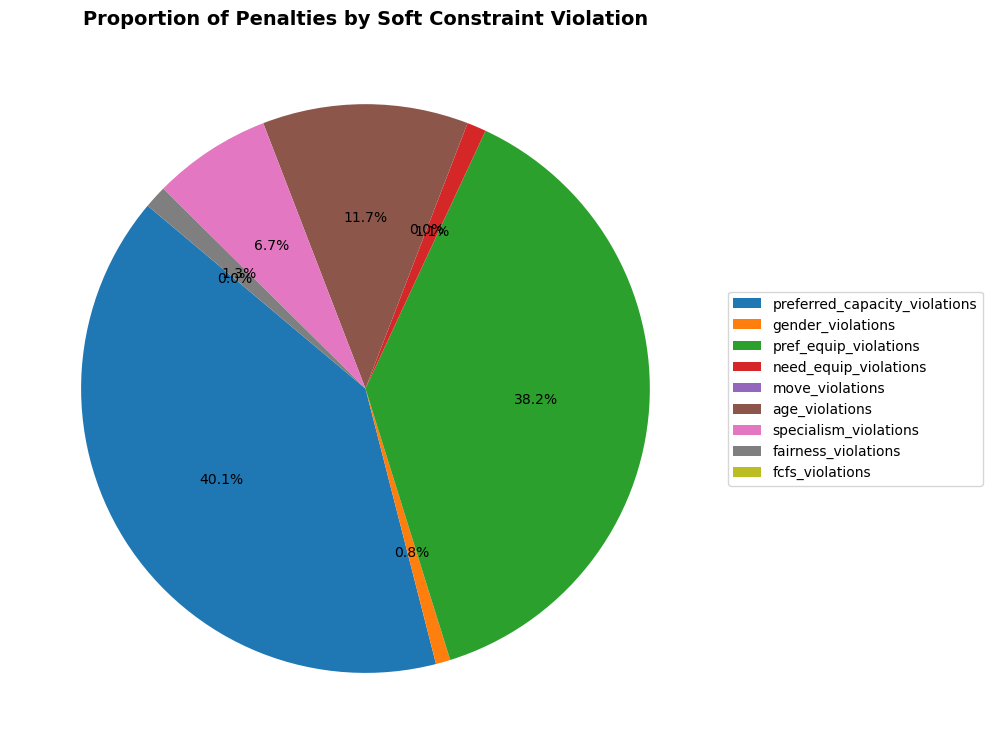

In [25]:
# Model 3 Historical Bias and FCFS 
# Main function to solve the hospital allocation problem
def solve_hospital_allocation():
    # 1) Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data() # Loads room and patient data
    random.seed(42) # Set random seed for reproducibility
    # Parse age limits for each department from a file
    department_age_limits = parse_department_ages("test9.txt") # Parses age constraints from a file

    # Metrics bookkeeping - Initialize variables to track performance and fairness
    total_duration = 0.0 # Total time taken to solve all days
    historical_penalties = {p.id: 0 for p in patients} # Dictionary to store cumulative penalties for each patient
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for the current day's assignments

    # 2) Horizon: days 0 … last admission day - Determine the range of days to consider
    last_admission_day = max(p.admission_day for p in patients) # Find the latest admission day among all patients
    all_days = range(last_admission_day + 1) # Create a range of all days from 0 up to the last admission day
    logs = {} # Dictionary for logging information (currently not used)
    all_assignments = {} # Dictionary to store assignment results for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation - Iterate through each day
    for current_day in all_days:
        print(f"Solving day {current_day}...") # Print the current day being solved
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Get penalties from the previous day
        max_prev_penalty = max(prev_penalties.values(), default=None) # Find the maximum penalty from the previous day

        # Identify patients present on the current day
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        if not present_patients: # If no patients are present, skip to the next day
            continue

        # Calculate fairness thresholds based on historical penalties or base penalties
        if current_day > 0:
            # For days after the first, calculate fairness scores considering historical penalties
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    # Calculate base penalty and apply bias based on historical penalty
                    base_pen = compatibility_penalty(p, r)
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1) # Avoid division by zero
                    fairness_score = base_pen * bias
                    all_fairness_scores.append(fairness_score)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else:
            # For the first day, calculate thresholds based on base penalties only
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r)
                    all_base_scores.append(base_pen)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_base_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # 3) CP-SAT Model Definition
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to store boolean variables representing patient-room assignments
        # Create a boolean variable for each possible patient-room assignment on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Constraints
        # Each patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment requirement constraint (Hard Constraint)
        # Determine the maximum number of equipment types to consider
        num_equipment_types = min(
            max(len(r.has) for r in rooms),
            max(len(p.needs) for p in present_patients)
        )

        # Enforce equipment need constraint for each equipment type
        for i in range(num_equipment_types):
            # Identify rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count of rooms with the equipment

            # Identify patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count of patients who need the equipment

            # Only enforce hard constraint if availability is greater than or equal to demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Ensure that a patient needing this equipment is assigned to a room that has it
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)


        # Soft Constraint Violations - Lists to store boolean variables for each type of violation
        viol_pref_cap = [] # Violations of preferred room capacity
        viol_gender = [] # Violations of gender preference
        viol_pref_eq = [] # Violations of preferred equipment
        viol_need_eq = [] # Violations of needed equipment (when not a hard constraint)
        viol_age = [] # Violations of department age limits
        viol_spec_minor = [] # Minor specialism mismatches (penalty 2)
        viol_spec_major = [] # Major specialism mismatches (penalty >= 3)
        viol_spec_mismatch = [] # Specialism not supported by the room
        viol_fairness_low = [] # Fairness violations below the low threshold
        viol_fairness_medium = [] # Fairness violations between low and high thresholds
        viol_fairness_high = [] # Fairness violations above the high threshold
        move_penalties = [] # Penalties for moving a patient to a different room
        viol_fcfs = [] # Violations of First-Come, First-Served (FCFS) principle


        # Populate the violation lists based on potential assignments
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the patient's previous room assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # The boolean variable for this patient-room assignment

                # Check for FCFS violation (new patient getting a better room than previous day's max penalty)
                if max_prev_penalty is not None and p.admission_day == current_day:
                    # Patient is newly admitted
                    pen = compatibility_penalty(p, r)
                    if pen < max_prev_penalty:
                        # New patient got better room than existing patients had yesterday
                        viol_fcfs.append(s)

                # Check for each type of soft constraint violation if this assignment is made
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s)
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s)
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s)

                equip_need_len = min(len(p.needs), len(r.has))
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s)
                # --- Generalized Age Constraint --- Check age limits based on department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s)

                # --- Specialism 1 --- Check penalty for the first specialism
                if p.specialism_id1 in r.spec_ids:
                    idx = r.spec_ids.index(p.specialism_id1)
                    pen = r.penalties[idx]
                    if pen == 2:
                        viol_spec_minor.append(s)
                    elif pen >= 3:
                        viol_spec_major.append(s)
                else:
                    viol_spec_mismatch.append(s)

                # --- Specialism 2 --- Check penalty for the second specialism if it exists
                if p.specialism_id2 is not None:
                    if p.specialism_id2 in r.spec_ids:
                        idx = r.spec_ids.index(p.specialism_id2)
                        pen = r.penalties[idx]
                        if pen == 2:
                            viol_spec_minor.append(s)
                        elif pen >= 3:
                            viol_spec_major.append(s)
                    else:
                        viol_spec_mismatch.append(s)

                # Calculate fairness score with historical penalty bias
                base_pen = compatibility_penalty(p, r)
                if current_day > 0:
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias
                else:
                    fairness_score = base_pen

                # Check for fairness violations based on calculated thresholds
                if fairness_score > threshold_high:
                    viol_fairness_high.append(s)
                elif fairness_score > threshold_low:
                    viol_fairness_medium.append(s)
                elif fairness_score < threshold_low:
                    viol_fairness_low.append(s)
                # --- Move Penalty --- Add penalty if the patient is moved to a different room
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s)

        # Total number of patient-seat pairs (for normalization) - Used to scale the objective function
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools - Helper function for scaling sums of boolean variables
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / normalizer)

        # Weights - Define weights for each type of soft constraint violation
        Wcap, Wgen, Wpeq, Wneq, Wage = 3, 5, 3, 10, 7
        Wspec_minor, Wspec_major, Wspec_mismatch = 2, 6, 8
        Wfair_low, Wfair_med, Wfair_high = 1, 3, 9
        Wmove, Wfcfs = 10, 6 # Added weight for FCFS violations

        # Minimize scaled and weighted sum - Define the objective function to minimize total weighted violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap)
            + Wgen * normalized_sum(viol_gender)
            + Wpeq * normalized_sum(viol_pref_eq)
            + Wneq * normalized_sum(viol_need_eq)
            + Wage * normalized_sum(viol_age)
            + Wspec_minor * normalized_sum(viol_spec_minor)
            + Wspec_major * normalized_sum(viol_spec_major)
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch)
            + Wfair_low * normalized_sum(viol_fairness_low)
            + Wfair_med * normalized_sum(viol_fairness_medium)
            + Wfair_high * normalized_sum(viol_fairness_high)
            + Wmove * normalized_sum(move_penalties)
            + Wfcfs * normalized_sum(viol_fcfs) # Added FCFS violation term to the objective
        )

        # 4) Solve the model for the current day
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the defined model
        day_duration = time.time() - start # Calculate the time taken to solve the day
        total_duration += day_duration # Add the day's duration to the total duration

        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}") # Print solving status and time

        # 5) Process results if a solution is found
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the assigned room for each patient
            violation_scores = [] # List to store detailed violation scores for each patient-assignment
            daily_score = 0 # Total penalty score for the current day

            # Iterate through present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true
                        assigned_room = r # Assign the room
                        assign[p.id] = r.id # Store the assignment
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient
                        break # Move to the next patient once the room is found

                # If a room was assigned, calculate its penalty and update historical penalties
                if assigned_room:
                    pen = compatibility_penalty(p, assigned_room) # Calculate the compatibility penalty
                    daily_score += pen # Add to the daily total score
                    historical_penalties[p.id] += pen  # Update cumulative historical penalties

                    # Example equipment labels (update this list to match your dataset's actual columns and order)
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']  # Ensure this matches the actual dataset

                    # Only consider the minimum length to avoid IndexError in cases of inconsistent data
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find missing equipment indices
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine effective lengths for equipment lists for violation checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations --- Count specialism violation types
                    spec_minor = 0
                    spec_major = 0
                    spec_mismatch = 0

                    # Specialism 1
                    if p.specialism_id1 in assigned_room.spec_ids:
                        idx = assigned_room.spec_ids.index(p.specialism_id1)
                        spec_pen = assigned_room.penalties[idx]
                        if spec_pen == 2:
                            spec_minor += 1
                        elif spec_pen >= 3:
                            spec_major += 1
                    else:
                        spec_mismatch += 1

                    # Specialism 2
                    if p.specialism_id2 is not None:
                        if p.specialism_id2 in assigned_room.spec_ids:
                            idx = assigned_room.spec_ids.index(p.specialism_id2)
                            spec_pen = assigned_room.penalties[idx]
                            if spec_pen == 2:
                                spec_minor += 1
                            elif spec_pen >= 3:
                                spec_major += 1
                        else:
                            spec_mismatch += 1

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen,
                        'historical_penalty': historical_penalties[p.id],
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if needed equipment is missing (and not a hard constraint violation), 0 otherwise
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)),  # 1 if age limit violated, 0 otherwise (Update if using dynamic department age limits)
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatches
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id)), # 1 if patient was moved, 0 otherwise
                            'fcfs': int( # 1 if FCFS violation occurred, 0 otherwise
                                p.admission_day == current_day and
                                max_prev_penalty is not None and
                                pen < max_prev_penalty
                            )
                        }
                    })

                # Save results
                all_assignments[current_day] = {
                    'assignments': assign, # Assigned room for each patient
                    'violation_scores': violation_scores # Detailed violation scores
                }

                # Violation Counters (dynamic for equipment length)
                move_count = sum(v['violations']['moved'] for v in violation_scores) # Count of patients who were moved


            # Store the assignments and violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of patients present
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores), # Total preferred capacity violations
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores), # Total gender violations
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores), # Total preferred equipment violations
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores), # Total needed equipment violations
                'age_violations': sum(v['violations']['age'] for v in violation_scores), # Total age violations
                'specialism_violations': sum( # Total specialism violations (sum of minor, major, mismatch)
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                'fcfs_violations': sum(v['violations']['fcfs'] for v in violation_scores), # Total FCFS violations
                'fairness_violations': sum(1 for v in violation_scores if v['total_score']  > threshold_low), # Total fairness violations (total score > low threshold)
                'total_violation_score': daily_score, # Total daily penalty score
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # 6) Final metrics and reporting - Calculate overall statistics and generate reports
    if results: # Proceed only if there are results
        df = pd.DataFrame(results) # Convert results list to a pandas DataFrame
        total_days = len(all_days) # Total number of days in the planning horizon
        success_rate = len(results) / total_days * 100 # Percentage of days successfully solved
        patient_ids = list(historical_penalties.keys()) # List of all patient IDs
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        penalty_vals = list(avg_daily_penalty.values()) # List of average daily penalty values

        # Calculate fairness metrics (Standard Deviation, Gini, Jain)
        std_dev = np.std(penalty_vals)
        gini = compute_gini(penalty_vals)
        jain = compute_jain(penalty_vals)

        # Calculate average penalties for all patients and find min/max
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        max_penalty_idx = np.argmax(penalty_vals) # Index of patient with maximum average daily penalty
        min_penalty_idx = np.argmin(penalty_vals) # Index of patient with minimum average daily penalty

        total_fairness_penalties = df['fairness_violations'].sum() # Calculate the total fairness violations across all days
        total_fcfs_penalties = df['fcfs_violations'].sum() # Calculate the total FCFS violations across all days

        print(f"Total Fairness Penalties: {total_fairness_penalties}") # Print total fairness penalties
        print(f"Total FCFS Penalties: {total_fcfs_penalties}") # Print total FCFS penalties

        # Build summary stats - Create a dictionary for the summary statistics table
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)",
                "Success Rate (%)",
                "Fairness - StdDev of Daily Penalty",
                "Fairness - Gini Coefficient",
                "Fairness - Jain Index",
                "Total Penalty - Mean",
                "Total Penalty - StdDev",
                "Total Penalty - Min",
                "Total Penalty - Max",
                "Avg Daily Penalty - Mean",
                "Avg Daily Penalty - StdDev",
                "Avg Daily Penalty - Min",
                "Avg Daily Penalty - Max",
                "Patients with Zero Penalty",
                "Patients with High Penalty (>mean+std)",
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})",
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})",
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total solving time
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of patients with high penalty
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Details for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Details for least penalized patient
            ]
        }

        # Create a DataFrame for the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False))
        # Save summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics9.csv", index=False)
        # Save summary statistics as a PNG image (table format)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        table = ax.table(cellText=summary_df.values, # Create table from DataFrame values
                         colLabels=summary_df.columns, # Use DataFrame columns as column labels
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table in the axes
        table.auto_set_font_size(False) # Disable automatic font sizing
        table.set_fontsize(10) # Set font size for table text
        table.scale(1, 1.2) # Scale the table size
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Add a title
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig("hospital_summary_statistics9.png", dpi=300) # Save the table as a PNG image
        plt.close() # Close the plot

        # Plots - Generate various plots to visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots

        # 1. Total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar chart
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-axis label
        axes[0,0].set_ylabel('Total Penalty') # Set y-axis label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

        # 2. Average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar chart
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-axis label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-axis label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-axis label
        axes[1,0].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-axis label
        axes[1,1].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary9.png") # Save the subplots as a PNG image
        plt.show() # Display the plots

        # Additional detailed penalty analysis
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing penalty distribution
        plt.subplot(2, 1, 1) # Create a subplot (2 rows, 1 column, 1st plot)
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-axis label

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary9.png") # Save the box plot as a PNG image
        plt.show() # Display the plot

        # Constraint Violations Over Time (Stacked Bar Chart)
        violation_cols = [ # List of columns representing different violation types
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations', 'fairness_violations', 'fcfs_violations'
        ]

        # Plot stacked bar chart of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Number of Violations") # Set y-axis label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time9.png") # Save the plot as a PNG image
        plt.show() # Display the plot

        # Proportion of Penalties by Soft Constraint Violation (Pie Chart)
        # Sum total violations for each type
        violation_totals = df[violation_cols].sum() # Calculate the sum of each violation type across all days

        plt.figure(figsize=(10, 10)) # Create a new figure
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels directly on slices
            autopct='%1.1f%%', # Format for percentage display
            startangle=140 # Starting angle for the first slice
        )
        # Add a legend with violation types and percentages
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold') # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart9.png", dpi=300) # Save the pie chart as a PNG image
        plt.show() # Display the plot

    # Return the results
    return all_assignments, rooms, patients, results

# Main execution block
if __name__ == "__main__":
    # Solve the hospital allocation problem
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark
        filename="hospital_assignment_report9.pdf" # Output filename for the PDF
    )

Solving day 0...
Day 0 (initial) thresholds - Low: 8.00, High: 16.00
Day 0 solved in 0.41s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 8.00, High: 17.00
Day 1 solved in 0.74s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 9.00, High: 18.00
Day 2 solved in 1.15s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 9.00, High: 19.00
Day 3 solved in 2.51s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 10.00, High: 20.80
Day 4 solved in 3.91s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 12.00, High: 24.50
Day 5 solved in 3.71s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 12.86, High: 27.14
Day 6 solved in 4.25s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 12.00, High: 25.50
Day 7 solved in 5.81s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 12.00, High: 25.33
Day 8 solved in 6.08s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 12.00, High: 23.40
Day 9 solved in 6.56s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 12.36, High: 24.73
Day 10 solve

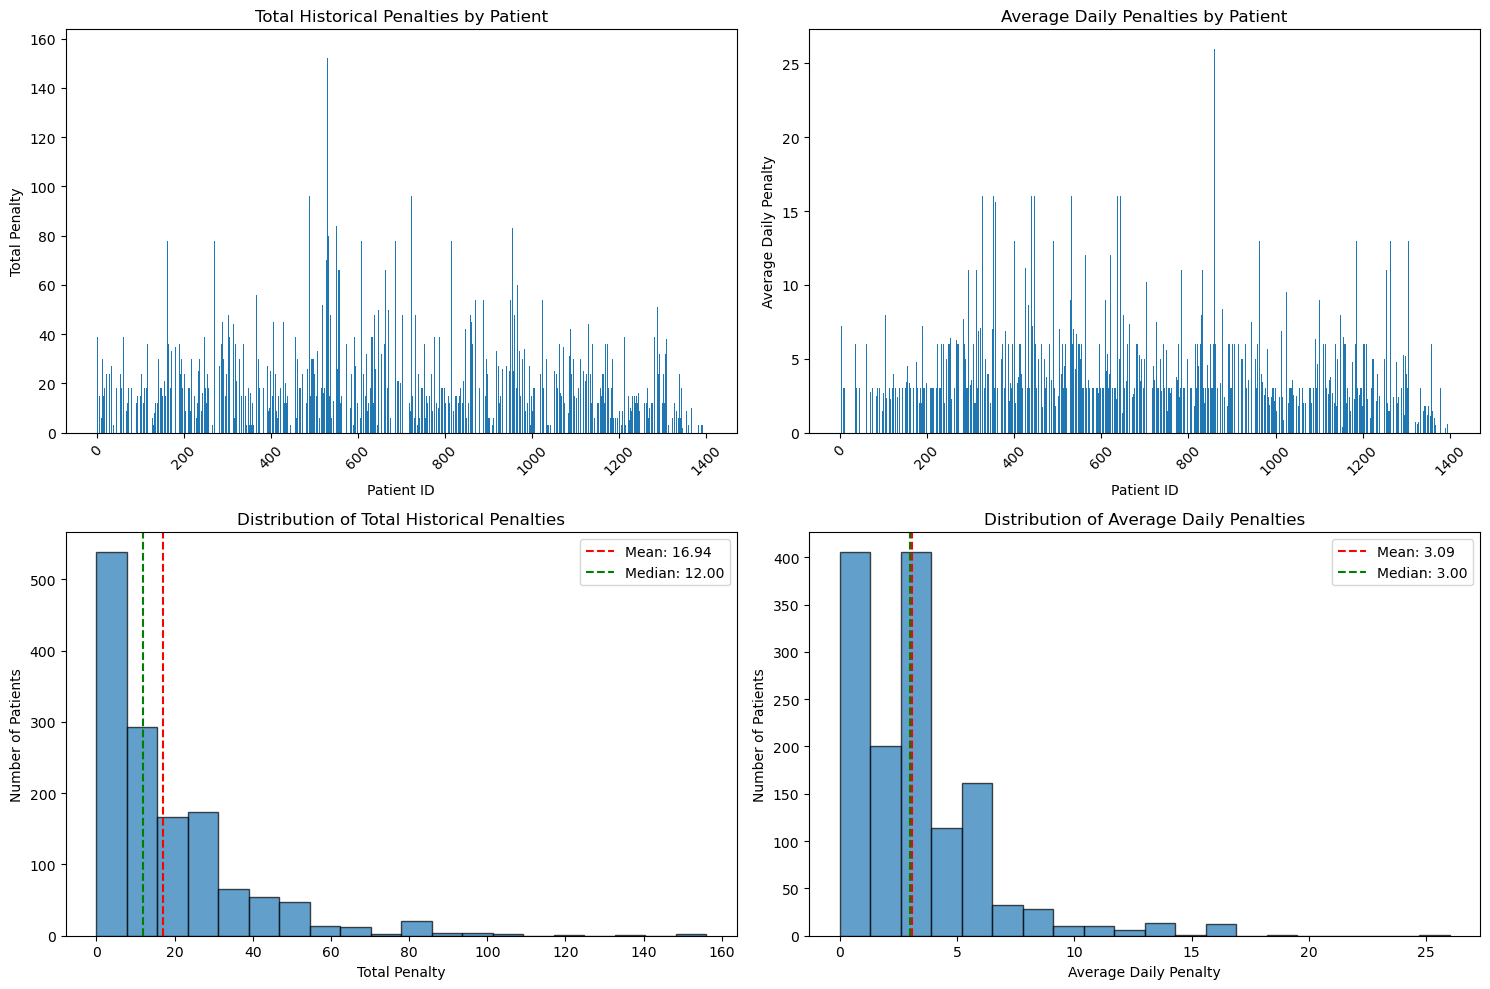

C:\Users\andri\AppData\Local\Temp\ipykernel_24016\3428396471.py:534: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot


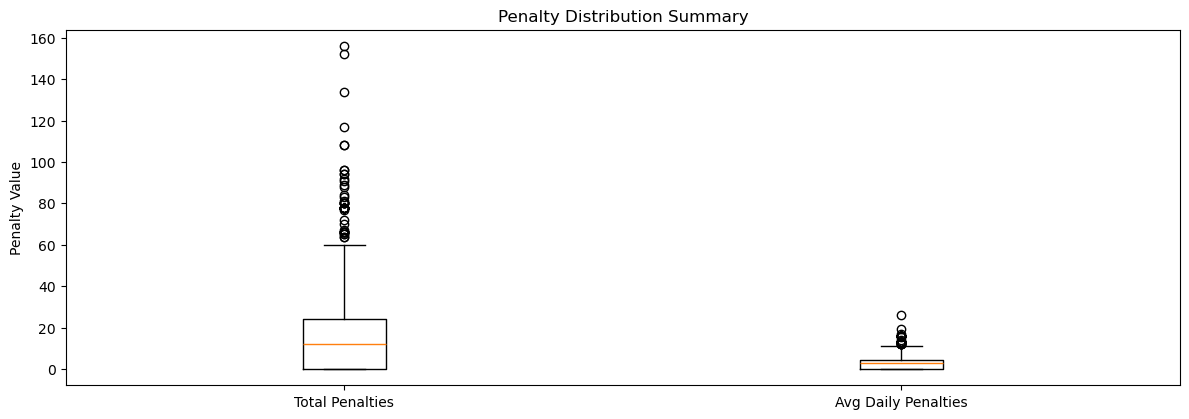

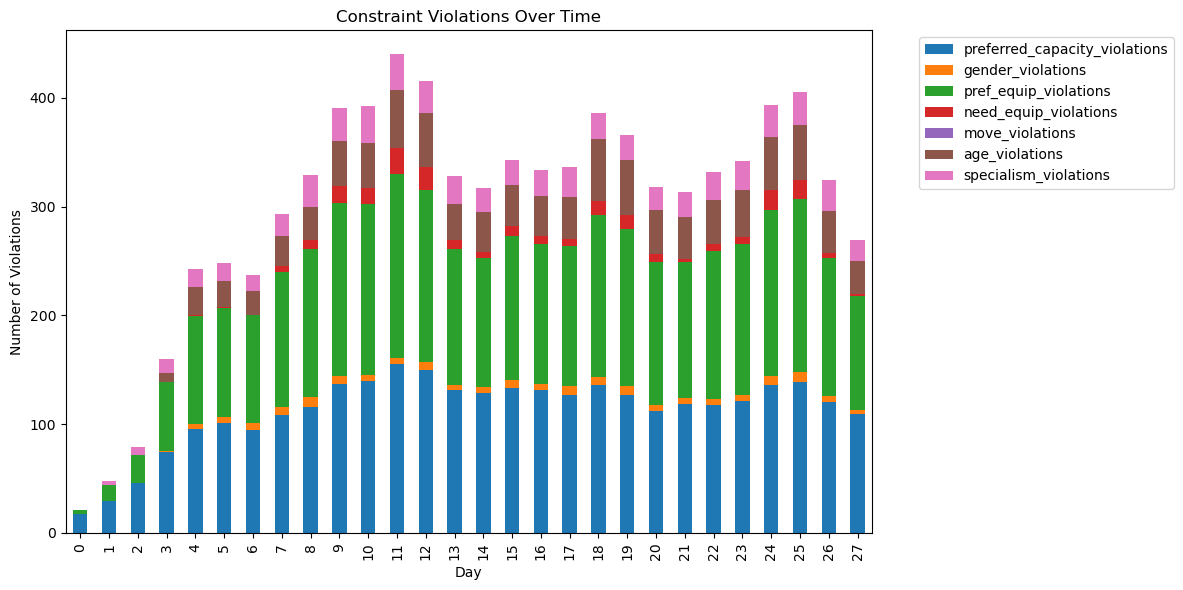

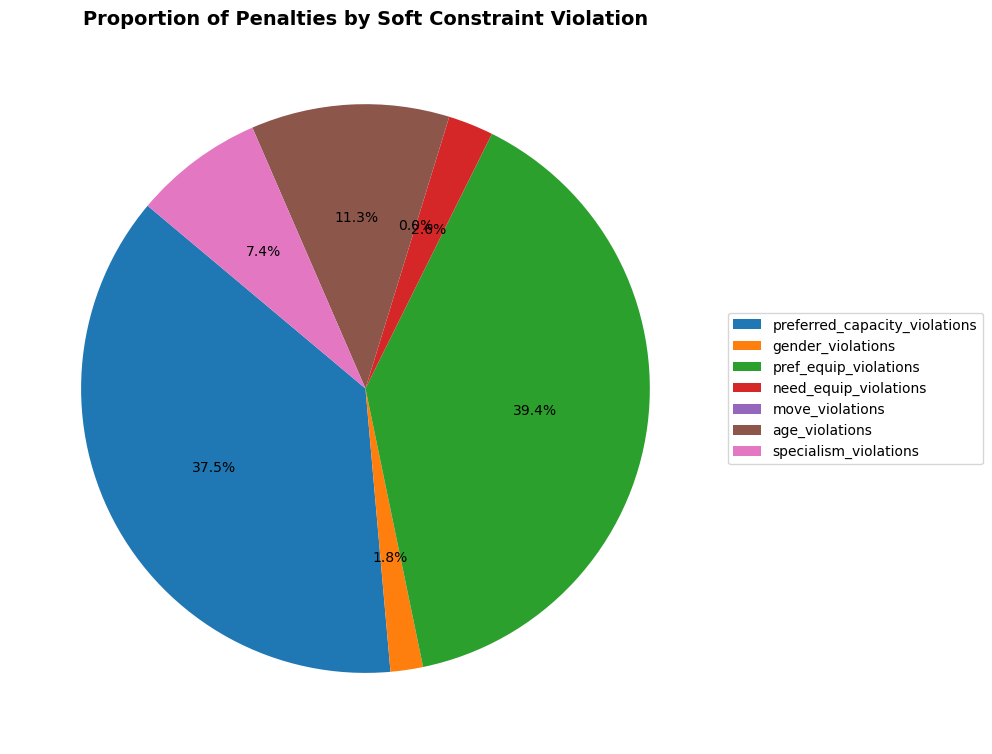

In [31]:
# Model 4, Basic Model with Uncertainty
# Main function to solve the hospital allocation problem
def solve_hospital_allocation():
    # 1) Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data() # Loads room and patient data
    random.seed(42) # Set random seed for reproducibility
    # Parse age limits for each department from a file
    department_age_limits = parse_department_ages("test9.txt") # Parses age constraints from a file

    # Metrics bookkeeping - Initialize variables to track performance and fairness
    total_duration = 0.0 # Total time taken to solve all days
    historical_penalties = {p.id: 0 for p in patients} # Dictionary to store cumulative penalties for each patient
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for the current day's assignments

    # 2) Horizon: days 0 … last admission day - Determine the range of days to consider
    last_admission_day = max(p.admission_day for p in patients) # Find the latest admission day among all patients
    all_days = range(last_admission_day + 1) # Create a range of all days from 0 up to the last admission day
    logs = {} # Dictionary for logging information (currently not used)
    all_assignments = {} # Dictionary to store assignment results for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation - Iterate through each day
    for current_day in all_days:
        print(f"Solving day {current_day}...") # Print the current day being solved
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Get penalties from the previous day
        max_prev_penalty = max(prev_penalties.values(), default=None) # Find the maximum penalty from the previous day

        # Simulate possible patient schedule changes ON THIS DAY - Introduce uncertainty in patient schedules
        for p in patients:

            # Delay admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of delay
                    delay = random.randint(1, 2) # Delay by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate original stay duration
                    p.admission_day += delay # Update admission day
                    p.release_day = p.admission_day + duration # Update release day

                    if not hasattr(p, "arrival_delays"): # Initialize list if it doesn't exist
                        p.arrival_delays = []
                    # Log the delay event
                    p.arrival_delays.append({
                        "day": current_day,
                        "delay": delay,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Early admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of early admission
                    advance = random.randint(1, 2) # Advance by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate original stay duration
                    p.admission_day = max(0, p.admission_day - advance) # Update admission day (ensure it's not negative)
                    p.release_day = p.admission_day + duration # Update release day

                    if not hasattr(p, "early_arrivals"): # Initialize list if it doesn't exist
                        p.early_arrivals = []
                    # Log the early arrival event
                    p.early_arrivals.append({
                        "day": current_day,
                        "advance": advance,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Late release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of late release
                    extension = random.randint(1, 2) # Extend by 1 or 2 days
                    p.release_day += extension # Update release day

                    if not hasattr(p, "late_releases"): # Initialize list if it doesn't exist
                        p.late_releases = []
                    # Log the late release event
                    p.late_releases.append({
                        "day": current_day,
                        "extension": extension,
                        "new_release": p.release_day,
                    })

            # Early release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of early release
                    reduction = random.randint(1, 2) # Reduce by 1 or 2 days
                    new_release = max(p.admission_day + 1, p.release_day - reduction) # Calculate new release day (ensure stay is at least 1 day)
                    if new_release < p.release_day: # Only log if release day actually changed
                        if not hasattr(p, "early_releases"): # Initialize list if it doesn't exist
                            p.early_releases = []
                        # Log the early release event
                        p.early_releases.append({
                            "day": current_day,
                            "early_by": p.release_day - new_release,
                            "new_release": new_release,
                        })
                        p.release_day = new_release # Update release day

        # Identify patients present on the current day after potential schedule changes
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        if not present_patients: # If no patients are present, skip to the next day
            continue

        # Calculate fairness thresholds based on historical penalties or base penalties
        if current_day > 0:
            # For days after the first, calculate fairness scores considering historical penalties
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    # Calculate base penalty and apply bias based on historical penalty
                    base_pen = compatibility_penalty(p, r)
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1) # Avoid division by zero
                    fairness_score = base_pen * bias
                    all_fairness_scores.append(fairness_score)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else:
            # For the first day, calculate thresholds based on base penalties only
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r)
                    all_base_scores.append(base_pen)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_base_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # 3) CP-SAT Model Definition
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to store boolean variables representing patient-room assignments
        # Create a boolean variable for each possible patient-room assignment on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Constraints
        # Each patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment requirement constraint (Hard Constraint)
        # Determine the maximum number of equipment types to consider
        num_equipment_types = min(
            max(len(r.has) for r in rooms),
            max(len(p.needs) for p in present_patients)
        )

        # Enforce equipment need constraint for each equipment type
        for i in range(num_equipment_types):
            # Identify rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count of rooms with the equipment

            # Identify patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count of patients who need the equipment

            # Only enforce hard constraint if availability is greater than or equal to demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Ensure that a patient needing this equipment is assigned to a room that has it
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)


        # Soft Constraint Violations - Lists to store boolean variables for each type of violation
        viol_pref_cap = [] # Violations of preferred room capacity
        viol_gender = [] # Violations of gender preference
        viol_pref_eq = [] # Violations of preferred equipment
        viol_need_eq = [] # Violations of needed equipment (when not a hard constraint)
        viol_age = [] # Violations of department age limits
        viol_spec_minor = [] # Minor specialism mismatches (penalty 2)
        viol_spec_major = [] # Major specialism mismatches (penalty >= 3)
        viol_spec_mismatch = [] # Specialism not supported by the room
        move_penalties = [] # Penalties for moving a patient to a different room


        # Populate the violation lists based on potential assignments
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the patient's previous room assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # The boolean variable for this patient-room assignment

                # Check for each type of soft constraint violation if this assignment is made
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s)
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s)
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s)

                equip_need_len = min(len(p.needs), len(r.has))
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s)
                # --- Generalized Age Constraint --- Check age limits based on department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s)

                # --- Specialism 1 --- Check penalty for the first specialism
                if p.specialism_id1 in r.spec_ids:
                    idx = r.spec_ids.index(p.specialism_id1)
                    pen = r.penalties[idx]
                    if pen == 2:
                        viol_spec_minor.append(s)
                    elif pen >= 3:
                        viol_spec_major.append(s)
                else:
                    viol_spec_mismatch.append(s)

                # --- Specialism 2 --- Check penalty for the second specialism if it exists
                if p.specialism_id2 is not None:
                    if p.specialism_id2 in r.spec_ids:
                        idx = r.spec_ids.index(p.specialism_id2)
                        pen = r.penalties[idx]
                        if pen == 2:
                            viol_spec_minor.append(s)
                        elif pen >= 3:
                            viol_spec_major.append(s)
                    else:
                        viol_spec_mismatch.append(s)

                # --- Move Penalty --- Add penalty if the patient is moved to a different room
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s)

        # Total number of patient-seat pairs (for normalization) - Used to scale the objective function
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools - Helper function for scaling sums of boolean variables
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / normalizer)

        # Weights - Define weights for each type of soft constraint violation
        Wcap, Wgen, Wpeq, Wneq, Wage = 3, 5, 3, 10, 7
        Wspec_minor, Wspec_major, Wspec_mismatch = 2, 6, 8
        Wmove = 10

        # Minimize scaled and weighted sum - Define the objective function to minimize total weighted violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap)
            + Wgen * normalized_sum(viol_gender)
            + Wpeq * normalized_sum(viol_pref_eq)
            + Wneq * normalized_sum(viol_need_eq)
            + Wage * normalized_sum(viol_age)
            + Wspec_minor * normalized_sum(viol_spec_minor)
            + Wspec_major * normalized_sum(viol_spec_major)
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch)
            + Wmove * normalized_sum(move_penalties)
        )

        # 4) Solve the model for the current day
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the defined model
        day_duration = time.time() - start # Calculate the time taken to solve the day
        total_duration += day_duration # Add the day's duration to the total duration

        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}") # Print solving status and time

        # 5) Process results if a solution is found
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the assigned room for each patient
            violation_scores = [] # List to store detailed violation scores for each patient-assignment
            daily_score = 0 # Total penalty score for the current day

            # Iterate through present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true
                        assigned_room = r # Assign the room
                        assign[p.id] = r.id # Store the assignment
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient
                        break # Move to the next patient once the room is found

                # If a room was assigned, calculate its penalty and update historical penalties
                if assigned_room:
                    pen = compatibility_penalty(p, assigned_room) # Calculate the compatibility penalty
                    daily_score += pen # Add to the daily total score
                    historical_penalties[p.id] += pen  # Update cumulative historical penalties

                    # Example equipment labels (update this list to match your dataset's actual columns and order)
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']  # Ensure this matches the actual dataset

                    # Only consider the minimum length to avoid IndexError in cases of inconsistent data
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find missing equipment indices
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine effective lengths for equipment lists for violation checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations --- Count specialism violation types
                    spec_minor = 0
                    spec_major = 0
                    spec_mismatch = 0

                    # Specialism 1
                    if p.specialism_id1 in assigned_room.spec_ids:
                        idx = assigned_room.spec_ids.index(p.specialism_id1)
                        spec_pen = assigned_room.penalties[idx]
                        if spec_pen == 2:
                            spec_minor += 1
                        elif spec_pen >= 3:
                            spec_major += 1
                    else:
                        spec_mismatch += 1

                    # Specialism 2
                    if p.specialism_id2 is not None:
                        if p.specialism_id2 in assigned_room.spec_ids:
                            idx = assigned_room.spec_ids.index(p.specialism_id2)
                            spec_pen = assigned_room.penalties[idx]
                            if spec_pen == 2:
                                spec_minor += 1
                            elif spec_pen >= 3:
                                spec_major += 1
                        else:
                            spec_mismatch += 1

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen,
                        'historical_penalty': historical_penalties[p.id],
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if needed equipment is missing (and not a hard constraint violation), 0 otherwise
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)),  # 1 if age limit violated, 0 otherwise (Update if using dynamic department age limits)
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatches
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id)) # 1 if patient was moved, 0 otherwise
                        }
                    })

                # Save results
                all_assignments[current_day] = {
                    'assignments': assign, # Assigned room for each patient
                    'violation_scores': violation_scores # Detailed violation scores
                }

                # Violation Counters (dynamic for equipment length)
                move_count = sum(v['violations']['moved'] for v in violation_scores) # Count of patients who were moved


            # Store the assignments and violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of patients present
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores), # Total preferred capacity violations
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores), # Total gender violations
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores), # Total preferred equipment violations
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores), # Total needed equipment violations
                'age_violations': sum(v['violations']['age'] for v in violation_scores), # Total age violations
                'specialism_violations': sum( # Total specialism violations (sum of minor, major, mismatch)
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                'total_violation_score': daily_score, # Total daily penalty score
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # 6) Final metrics and reporting - Calculate overall statistics and generate reports
    if results: # Proceed only if there are results
        df = pd.DataFrame(results) # Convert results list to a pandas DataFrame
        total_days = len(all_days) # Total number of days in the planning horizon
        success_rate = len(results) / total_days * 100 # Percentage of days successfully solved
        patient_ids = list(historical_penalties.keys()) # List of all patient IDs
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        penalty_vals = list(avg_daily_penalty.values()) # List of average daily penalty values

        # Calculate fairness metrics (Standard Deviation, Gini, Jain)
        std_dev = np.std(penalty_vals)
        gini = compute_gini(penalty_vals)
        jain = compute_jain(penalty_vals)

        # Calculate average penalties for all patients and find min/max
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        max_penalty_idx = np.argmax(penalty_vals) # Index of patient with maximum average daily penalty
        min_penalty_idx = np.argmin(penalty_vals) # Index of patient with minimum average daily penalty

        # Build summary stats - Create a dictionary for the summary statistics table
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)",
                "Success Rate (%)",
                "Fairness - StdDev of Daily Penalty",
                "Fairness - Gini Coefficient",
                "Fairness - Jain Index",
                "Total Penalty - Mean",
                "Total Penalty - StdDev",
                "Total Penalty - Min",
                "Total Penalty - Max",
                "Avg Daily Penalty - Mean",
                "Avg Daily Penalty - StdDev",
                "Avg Daily Penalty - Min",
                "Avg Daily Penalty - Max",
                "Patients with Zero Penalty",
                "Patients with High Penalty (>mean+std)",
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})",
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})",
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total solving time
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of patients with high penalty
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Details for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Details for least penalized patient
            ]
        }

        # Create a DataFrame for the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False))
        # Save summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics9.csv", index=False)
        # Save summary statistics as a PNG image (table format)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        table = ax.table(cellText=summary_df.values, # Create table from DataFrame values
                         colLabels=summary_df.columns, # Use DataFrame columns as column labels
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table in the axes
        table.auto_set_font_size(False) # Disable automatic font sizing
        table.set_fontsize(10) # Set font size for table text
        table.scale(1, 1.2) # Scale the table size
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Add a title
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig("hospital_summary_statistics9.png", dpi=300) # Save the table as a PNG image
        plt.close() # Close the plot

        # Plots - Generate various plots to visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots

        # 1. Total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar chart
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-axis label
        axes[0,0].set_ylabel('Total Penalty') # Set y-axis label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

        # 2. Average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar chart
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-axis label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-axis label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-axis label
        axes[1,0].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-axis label
        axes[1,1].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary9.png") # Save the subplots as a PNG image
        plt.show() # Display the plots

        # Additional detailed penalty analysis
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing penalty distribution
        plt.subplot(2, 1, 1) # Create a subplot (2 rows, 1 column, 1st plot)
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-axis label

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary9.png") # Save the box plot as a PNG image
        plt.show() # Display the plot

        # Constraint Violations Over Time (Stacked Bar Chart)
        violation_cols = [ # List of columns representing different violation types
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations'
        ]

        # Plot stacked bar chart of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Number of Violations") # Set y-axis label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time9.png") # Save the plot as a PNG image
        plt.show() # Display the plot

        # Proportion of Penalties by Soft Constraint Violation (Pie Chart)
        # Sum total violations for each type
        violation_totals = df[violation_cols].sum() # Calculate the sum of each violation type across all days

        plt.figure(figsize=(10, 10)) # Create a new figure
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels directly on slices
            autopct='%1.1f%%', # Format for percentage display
            startangle=140 # Starting angle for the first slice
        )
        # Add a legend with violation types and percentages
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold') # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart9.png", dpi=300) # Save the pie chart as a PNG image
        plt.show() # Display the plot

    # Return the results
    return all_assignments, rooms, patients, results

# Main execution block
if __name__ == "__main__":
    # Solve the hospital allocation problem
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark
        filename="hospital_assignment_report9.pdf" # Output filename for the PDF
    )

Solving day 0...
Day 0 (initial) thresholds - Low: 8.00, High: 16.00
Day 0 solved in 0.40s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 8.00, High: 17.00
Day 1 solved in 0.72s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 9.00, High: 18.00
Day 2 solved in 1.19s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 9.00, High: 18.00
Day 3 solved in 2.33s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 10.00, High: 20.40
Day 4 solved in 3.81s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 12.00, High: 24.00
Day 5 solved in 4.59s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 12.86, High: 26.29
Day 6 solved in 4.15s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 12.00, High: 24.00
Day 7 solved in 5.65s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 12.00, High: 24.00
Day 8 solved in 5.92s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 11.40, High: 22.00
Day 9 solved in 6.56s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 12.36, High: 24.00
Day 10 solve

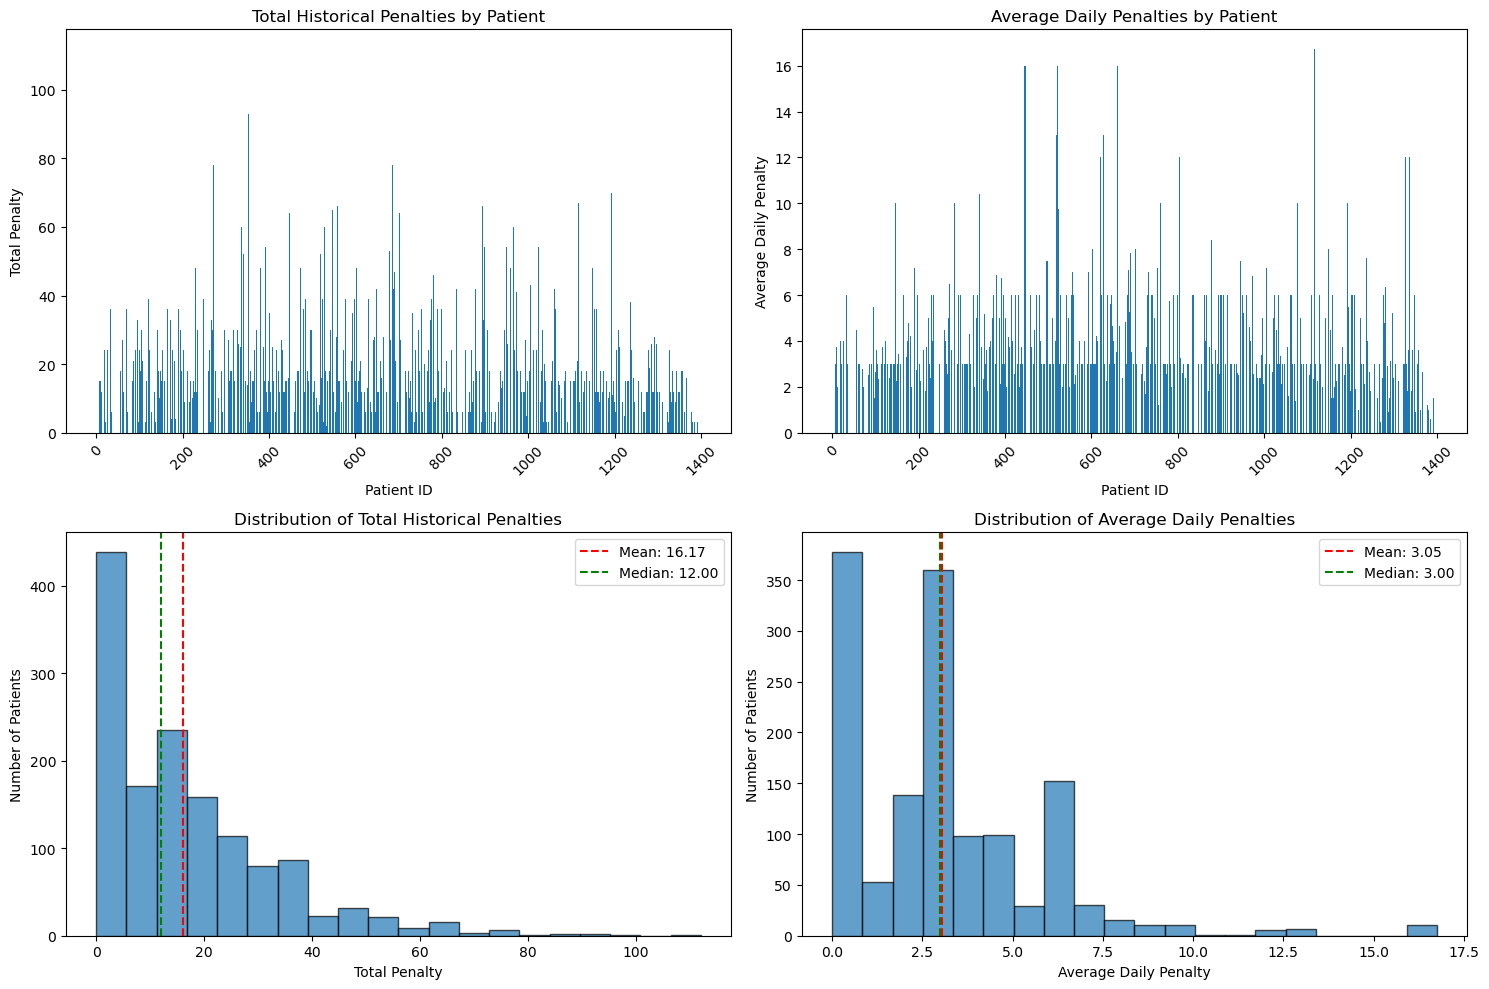

C:\Users\andri\AppData\Local\Temp\ipykernel_24016\667988401.py:560: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot


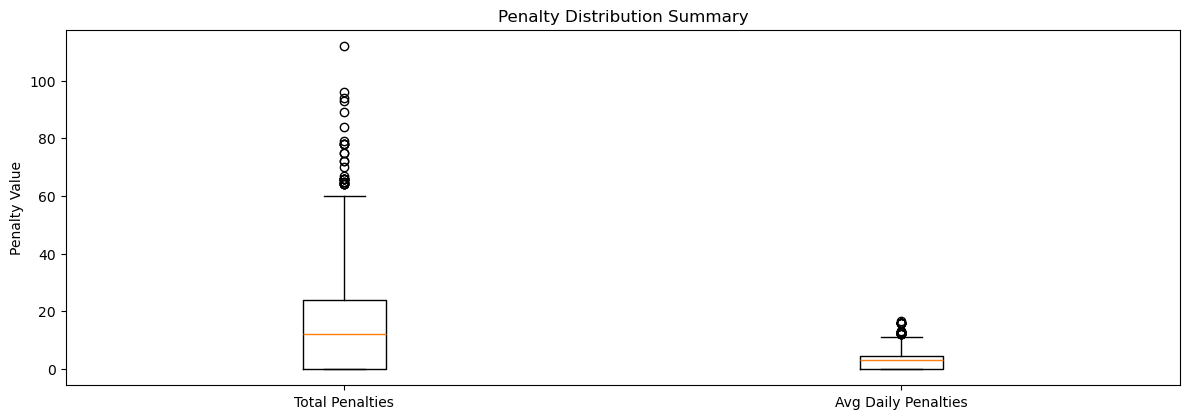

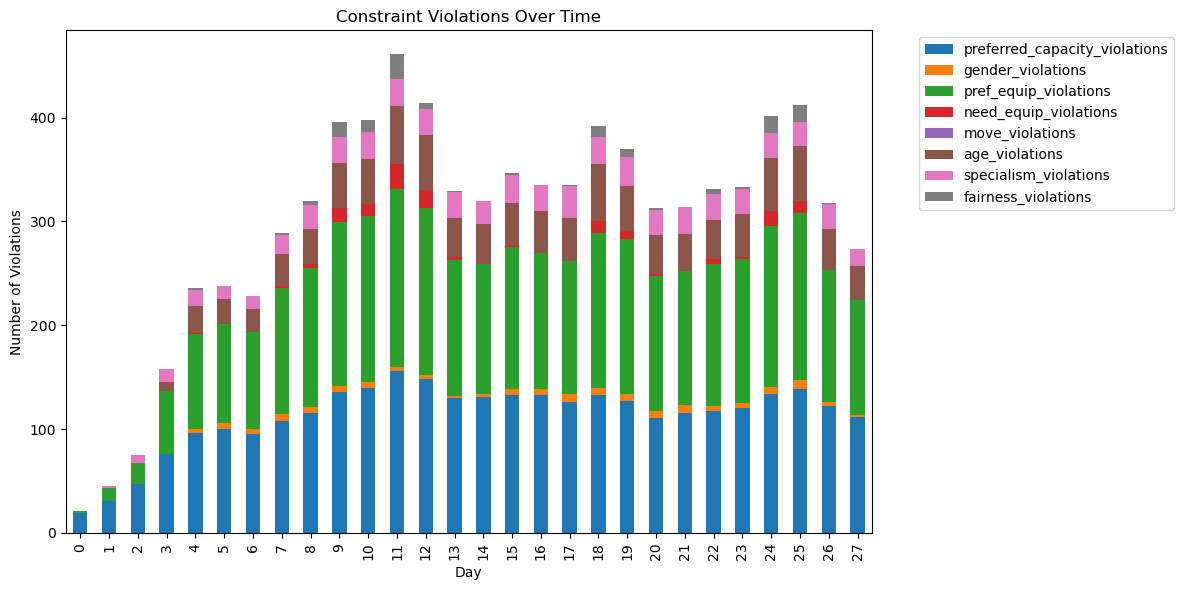

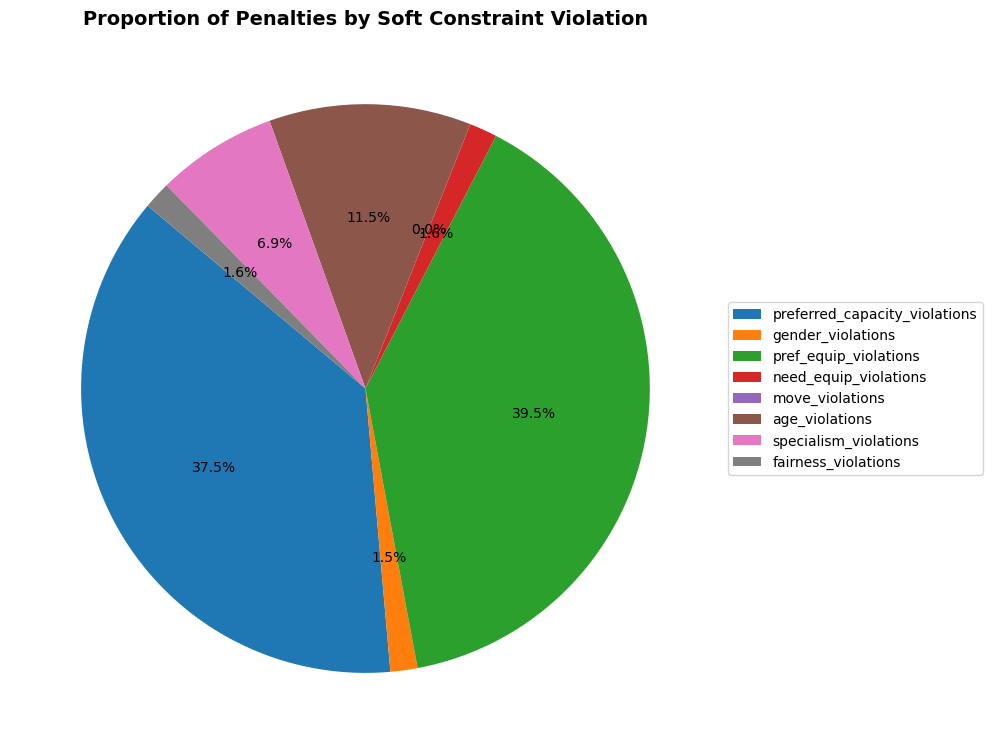

In [29]:
# Model 5, Historical Bias with Uncertainty
# Main function to solve the hospital allocation problem
def solve_hospital_allocation():
    # 1) Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data() # Loads room and patient data
    random.seed(42) # Set random seed for reproducibility
    # Parse age limits for each department from a file
    department_age_limits = parse_department_ages("test9.txt") # Parses age constraints from a file

    # Metrics bookkeeping - Initialize variables to track performance and fairness
    total_duration = 0.0 # Total time taken to solve all days
    historical_penalties = {p.id: 0 for p in patients} # Dictionary to store cumulative penalties for each patient
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for the current day's assignments

    # 2) Horizon: days 0 … last admission day - Determine the range of days to consider
    last_admission_day = max(p.admission_day for p in patients) # Find the latest admission day among all patients
    all_days = range(last_admission_day + 1) # Create a range of all days from 0 up to the last admission day
    logs = {} # Dictionary for logging information (currently not used)
    all_assignments = {} # Dictionary to store assignment results for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation - Iterate through each day
    for current_day in all_days:
        print(f"Solving day {current_day}...") # Print the current day being solved
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Get penalties from the previous day
        max_prev_penalty = max(prev_penalties.values(), default=None) # Find the maximum penalty from the previous day

        # Simulate possible patient schedule changes ON THIS DAY - Introduce uncertainty in patient schedules
        for p in patients:

            # Delay admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of delay
                    delay = random.randint(1, 2) # Delay by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate original stay duration
                    p.admission_day += delay # Update admission day
                    p.release_day = p.admission_day + duration # Update release day

                    if not hasattr(p, "arrival_delays"): # Initialize list if it doesn't exist
                        p.arrival_delays = []
                    # Log the delay event
                    p.arrival_delays.append({
                        "day": current_day,
                        "delay": delay,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Early admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of early admission
                    advance = random.randint(1, 2) # Advance by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate original stay duration
                    p.admission_day = max(0, p.admission_day - advance) # Update admission day (ensure it's not negative)
                    p.release_day = p.admission_day + duration # Update release day

                    if not hasattr(p, "early_arrivals"): # Initialize list if it doesn't exist
                        p.early_arrivals = []
                    # Log the early arrival event
                    p.early_arrivals.append({
                        "day": current_day,
                        "advance": advance,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Late release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of late release
                    extension = random.randint(1, 2) # Extend by 1 or 2 days
                    p.release_day += extension # Update release day

                    if not hasattr(p, "late_releases"): # Initialize list if it doesn't exist
                        p.late_releases = []
                    # Log the late release event
                    p.late_releases.append({
                        "day": current_day,
                        "extension": extension,
                        "new_release": p.release_day,
                    })

            # Early release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of early release
                    reduction = random.randint(1, 2) # Reduce by 1 or 2 days
                    new_release = max(p.admission_day + 1, p.release_day - reduction) # Calculate new release day (ensure stay is at least 1 day)
                    if new_release < p.release_day: # Only log if release day actually changed
                        if not hasattr(p, "early_releases"): # Initialize list if it doesn't exist
                            p.early_releases = []
                        # Log the early release event
                        p.early_releases.append({
                            "day": current_day,
                            "early_by": p.release_day - new_release,
                            "new_release": new_release,
                        })
                        p.release_day = new_release # Update release day

        # Identify patients present on the current day after potential schedule changes
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        if not present_patients: # If no patients are present, skip to the next day
            continue

        # Calculate fairness thresholds based on historical penalties or base penalties
        if current_day > 0:
            # For days after the first, calculate fairness scores considering historical penalties
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    # Calculate base penalty and apply bias based on historical penalty
                    base_pen = compatibility_penalty(p, r)
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1) # Avoid division by zero
                    fairness_score = base_pen * bias
                    all_fairness_scores.append(fairness_score)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else:
            # For the first day, calculate thresholds based on base penalties only
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r)
                    all_base_scores.append(base_pen)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_base_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # 3) CP-SAT Model Definition
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to store boolean variables representing patient-room assignments
        # Create a boolean variable for each possible patient-room assignment on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Constraints
        # Each patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment requirement constraint (Hard Constraint)
        # Determine the maximum number of equipment types to consider
        num_equipment_types = min(
            max(len(r.has) for r in rooms),
            max(len(p.needs) for p in present_patients)
        )

        # Enforce equipment need constraint for each equipment type
        for i in range(num_equipment_types):
            # Identify rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count of rooms with the equipment

            # Identify patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count of patients who need the equipment

            # Only enforce hard constraint if availability is greater than or equal to demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Ensure that a patient needing this equipment is assigned to a room that has it
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)


        # Soft Constraint Violations - Lists to store boolean variables for each type of violation
        viol_pref_cap = [] # Violations of preferred room capacity
        viol_gender = [] # Violations of gender preference
        viol_pref_eq = [] # Violations of preferred equipment
        viol_need_eq = [] # Violations of needed equipment (when not a hard constraint)
        viol_age = [] # Violations of department age limits
        viol_spec_minor = [] # Minor specialism mismatches (penalty 2)
        viol_spec_major = [] # Major specialism mismatches (penalty >= 3)
        viol_spec_mismatch = [] # Specialism not supported by the room
        viol_fairness_low = [] # Fairness violations below the low threshold
        viol_fairness_medium = [] # Fairness violations between low and high thresholds
        viol_fairness_high = [] # Fairness violations above the high threshold
        move_penalties = [] # Penalties for moving a patient to a different room


        # Populate the violation lists based on potential assignments
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the patient's previous room assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # The boolean variable for this patient-room assignment

                # Check for each type of soft constraint violation if this assignment is made
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s)
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s)
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s)

                equip_need_len = min(len(p.needs), len(r.has))
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s)
                # --- Generalized Age Constraint --- Check age limits based on department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s)

                # --- Specialism 1 --- Check penalty for the first specialism
                if p.specialism_id1 in r.spec_ids:
                    idx = r.spec_ids.index(p.specialism_id1)
                    pen = r.penalties[idx]
                    if pen == 2:
                        viol_spec_minor.append(s)
                    elif pen >= 3:
                        viol_spec_major.append(s)
                else:
                    viol_spec_mismatch.append(s)

                # --- Specialism 2 --- Check penalty for the second specialism if it exists
                if p.specialism_id2 is not None:
                    if p.specialism_id2 in r.spec_ids:
                        idx = r.spec_ids.index(p.specialism_id2)
                        pen = r.penalties[idx]
                        if pen == 2:
                            viol_spec_minor.append(s)
                        elif pen >= 3:
                            viol_spec_major.append(s)
                    else:
                        viol_spec_mismatch.append(s)

                # Calculate fairness score with historical penalty bias
                base_pen = compatibility_penalty(p, r)
                if current_day > 0:
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias
                else:
                    fairness_score = base_pen

                # Check for fairness violations based on calculated thresholds
                if fairness_score > threshold_high:
                    viol_fairness_high.append(s)
                elif fairness_score > threshold_low:
                    viol_fairness_medium.append(s)
                elif fairness_score < threshold_low:
                    viol_fairness_low.append(s)
                # --- Move Penalty --- Add penalty if the patient is moved to a different room
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s)

        # Total number of patient-seat pairs (for normalization) - Used to scale the objective function
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools - Helper function for scaling sums of boolean variables
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / normalizer)

        # Weights - Define weights for each type of soft constraint violation
        Wcap, Wgen, Wpeq, Wneq, Wage = 3, 5, 3, 10, 7
        Wspec_minor, Wspec_major, Wspec_mismatch = 2, 6, 8
        Wfair_low, Wfair_med, Wfair_high = 1, 3, 9
        Wmove = 10

        # Minimize scaled and weighted sum - Define the objective function to minimize total weighted violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap)
            + Wgen * normalized_sum(viol_gender)
            + Wpeq * normalized_sum(viol_pref_eq)
            + Wneq * normalized_sum(viol_need_eq)
            + Wage * normalized_sum(viol_age)
            + Wspec_minor * normalized_sum(viol_spec_minor)
            + Wspec_major * normalized_sum(viol_spec_major)
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch)
            + Wfair_low * normalized_sum(viol_fairness_low)
            + Wfair_med * normalized_sum(viol_fairness_medium)
            + Wfair_high * normalized_sum(viol_fairness_high)
            + Wmove * normalized_sum(move_penalties)
        )

        # 4) Solve the model for the current day
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the defined model
        day_duration = time.time() - start # Calculate the time taken to solve the day
        total_duration += day_duration # Add the day's duration to the total duration

        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}") # Print solving status and time

        # 5) Process results if a solution is found
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the assigned room for each patient
            violation_scores = [] # List to store detailed violation scores for each patient-assignment
            daily_score = 0 # Total penalty score for the current day

            # Iterate through present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true
                        assigned_room = r # Assign the room
                        assign[p.id] = r.id # Store the assignment
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient
                        break # Move to the next patient once the room is found

                # If a room was assigned, calculate its penalty and update historical penalties
                if assigned_room:
                    pen = compatibility_penalty(p, assigned_room) # Calculate the compatibility penalty
                    daily_score += pen # Add to the daily total score
                    historical_penalties[p.id] += pen  # Update cumulative historical penalties

                    # Example equipment labels (update this list to match your dataset's actual columns and order)
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']  # Ensure this matches the actual dataset

                    # Only consider the minimum length to avoid IndexError in cases of inconsistent data
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find missing equipment indices
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine effective lengths for equipment lists for violation checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations --- Count specialism violation types
                    spec_minor = 0
                    spec_major = 0
                    spec_mismatch = 0

                    # Specialism 1
                    if p.specialism_id1 in assigned_room.spec_ids:
                        idx = assigned_room.spec_ids.index(p.specialism_id1)
                        spec_pen = assigned_room.penalties[idx]
                        if spec_pen == 2:
                            spec_minor += 1
                        elif spec_pen >= 3:
                            spec_major += 1
                    else:
                        spec_mismatch += 1

                    # Specialism 2
                    if p.specialism_id2 is not None:
                        if p.specialism_id2 in assigned_room.spec_ids:
                            idx = assigned_room.spec_ids.index(p.specialism_id2)
                            spec_pen = assigned_room.penalties[idx]
                            if spec_pen == 2:
                                spec_minor += 1
                            elif spec_pen >= 3:
                                spec_major += 1
                        else:
                            spec_mismatch += 1

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen,
                        'historical_penalty': historical_penalties[p.id],
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if needed equipment is missing (and not a hard constraint violation), 0 otherwise
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)),  # 1 if age limit violated, 0 otherwise (Update if using dynamic department age limits)
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatches
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id)) # 1 if patient was moved, 0 otherwise
                        }
                    })

                # Save results
                all_assignments[current_day] = {
                    'assignments': assign, # Assigned room for each patient
                    'violation_scores': violation_scores # Detailed violation scores
                }

                # Violation Counters (dynamic for equipment length)
                move_count = sum(v['violations']['moved'] for v in violation_scores) # Count of patients who were moved


            # Store the assignments and violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of patients present
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores), # Total preferred capacity violations
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores), # Total gender violations
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores), # Total preferred equipment violations
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores), # Total needed equipment violations
                'age_violations': sum(v['violations']['age'] for v in violation_scores), # Total age violations
                'specialism_violations': sum( # Total specialism violations (sum of minor, major, mismatch)
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                'fairness_violations': sum(1 for v in violation_scores if v['total_score']  > threshold_low), # Total fairness violations (total score > low threshold)
                'total_violation_score': daily_score, # Total daily penalty score
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # 6) Final metrics and reporting - Calculate overall statistics and generate reports
    if results: # Proceed only if there are results
        df = pd.DataFrame(results) # Convert results list to a pandas DataFrame
        total_days = len(all_days) # Total number of days in the planning horizon
        success_rate = len(results) / total_days * 100 # Percentage of days successfully solved
        patient_ids = list(historical_penalties.keys()) # List of all patient IDs
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        penalty_vals = list(avg_daily_penalty.values()) # List of average daily penalty values

        # Calculate fairness metrics (Standard Deviation, Gini, Jain)
        std_dev = np.std(penalty_vals)
        gini = compute_gini(penalty_vals)
        jain = compute_jain(penalty_vals)

        # Calculate average penalties for all patients and find min/max
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        max_penalty_idx = np.argmax(penalty_vals) # Index of patient with maximum average daily penalty
        min_penalty_idx = np.argmin(penalty_vals) # Index of patient with minimum average daily penalty

        total_fairness_penalties = df['fairness_violations'].sum() # Calculate the total fairness violations across all days
        print(f"Total Fairness Penalties: {total_fairness_penalties}") # Print total fairness penalties

        # Build summary stats - Create a dictionary for the summary statistics table
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)",
                "Success Rate (%)",
                "Fairness - StdDev of Daily Penalty",
                "Fairness - Gini Coefficient",
                "Fairness - Jain Index",
                "Total Penalty - Mean",
                "Total Penalty - StdDev",
                "Total Penalty - Min",
                "Total Penalty - Max",
                "Avg Daily Penalty - Mean",
                "Avg Daily Penalty - StdDev",
                "Avg Daily Penalty - Min",
                "Avg Daily Penalty - Max",
                "Patients with Zero Penalty",
                "Patients with High Penalty (>mean+std)",
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})",
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})",
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total solving time
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of patients with high penalty
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Details for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Details for least penalized patient
            ]
        }

        # Create a DataFrame for the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False))
        # Save summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics9.csv", index=False)
        # Save summary statistics as a PNG image (table format)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        table = ax.table(cellText=summary_df.values, # Create table from DataFrame values
                         colLabels=summary_df.columns, # Use DataFrame columns as column labels
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table in the axes
        table.auto_set_font_size(False) # Disable automatic font sizing
        table.set_fontsize(10) # Set font size for table text
        table.scale(1, 1.2) # Scale the table size
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Add a title
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig("hospital_summary_statistics3.png", dpi=300) # Save the table as a PNG image
        plt.close() # Close the plot

        # Plots - Generate various plots to visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots

        # 1. Total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar chart
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-axis label
        axes[0,0].set_ylabel('Total Penalty') # Set y-axis label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

        # 2. Average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar chart
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-axis label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-axis label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-axis label
        axes[1,0].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-axis label
        axes[1,1].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary9.png") # Save the subplots as a PNG image
        plt.show() # Display the plots

        # Additional detailed penalty analysis
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing penalty distribution
        plt.subplot(2, 1, 1) # Create a subplot (2 rows, 1 column, 1st plot)
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-axis label

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary9.png") # Save the box plot as a PNG image
        plt.show() # Display the plot

        # Constraint Violations Over Time (Stacked Bar Chart)
        violation_cols = [ # List of columns representing different violation types
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations', 'fairness_violations'
        ]

        # Plot stacked bar chart of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Number of Violations") # Set y-axis label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time9.png") # Save the plot as a PNG image
        plt.show() # Display the plot

        # Proportion of Penalties by Soft Constraint Violation (Pie Chart)
        # Sum total violations for each type
        violation_totals = df[violation_cols].sum() # Calculate the sum of each violation type across all days

        plt.figure(figsize=(10, 10)) # Create a new figure
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels directly on slices
            autopct='%1.1f%%', # Format for percentage display
            startangle=140 # Starting angle for the first slice
        )
        # Add a legend with violation types and percentages
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold') # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart9.png", dpi=300) # Save the pie chart as a PNG image
        plt.show() # Display the plot

    # Return the results
    return all_assignments, rooms, patients, results

# Main execution block
if __name__ == "__main__":
    # Solve the hospital allocation problem
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark
        filename="hospital_assignment_report9.pdf" # Output filename for the PDF
    )

Solving day 0...
Day 0 (initial) thresholds - Low: 8.00, High: 16.00
Day 0 solved in 0.43s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 8.00, High: 17.00
Day 1 solved in 0.73s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 9.00, High: 18.00
Day 2 solved in 1.18s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 9.00, High: 18.00
Day 3 solved in 2.50s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 10.00, High: 20.40
Day 4 solved in 3.98s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 12.00, High: 24.00
Day 5 solved in 3.56s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 12.00, High: 25.71
Day 6 solved in 3.38s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 12.00, High: 24.00
Day 7 solved in 4.34s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 12.00, High: 24.00
Day 8 solved in 5.80s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 11.70, High: 22.45
Day 9 solved in 5.27s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 12.36, High: 24.00
Day 10 solve

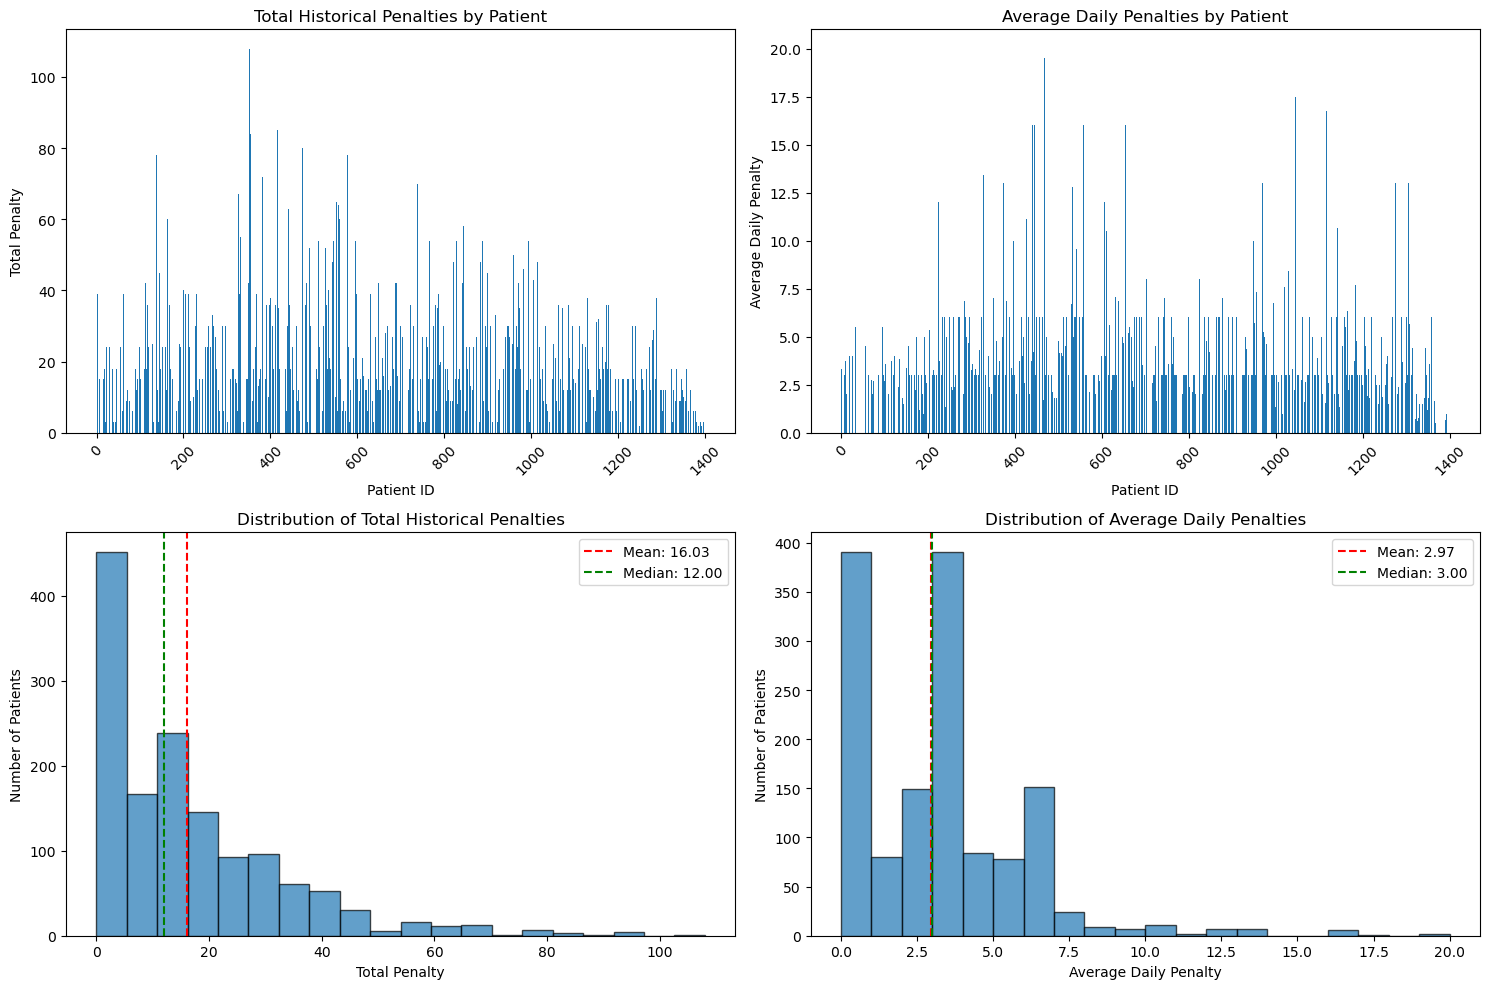

C:\Users\andri\AppData\Local\Temp\ipykernel_24016\1910666616.py:570: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot


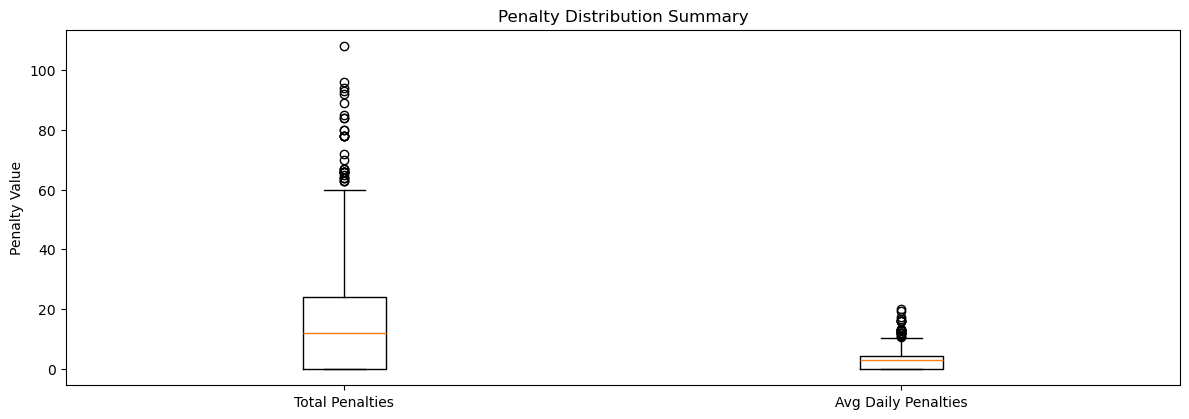

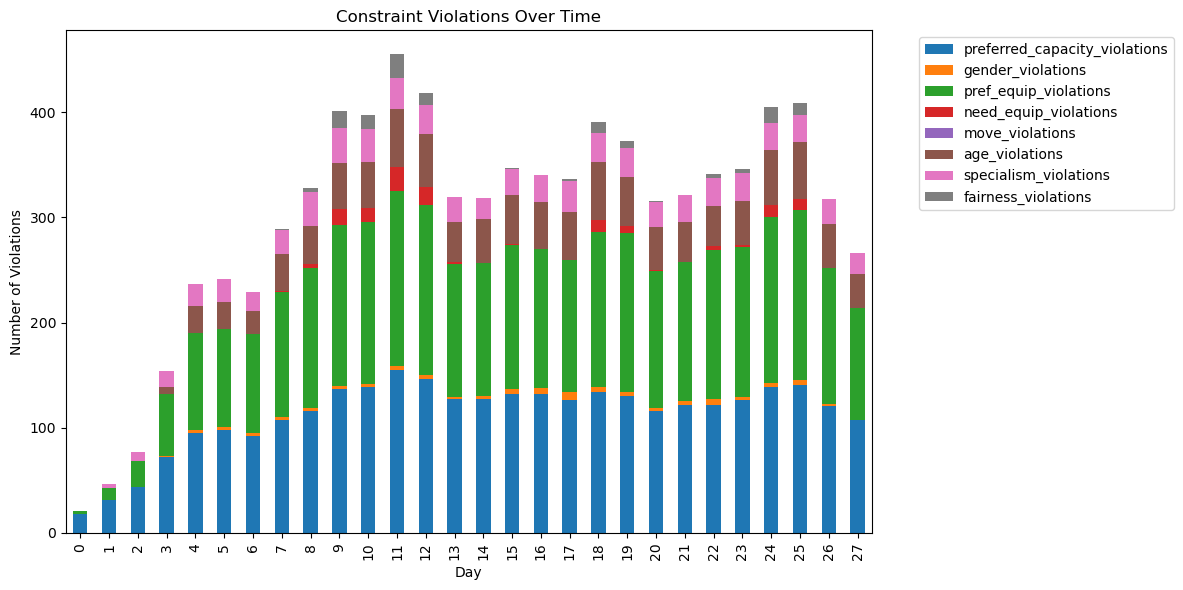

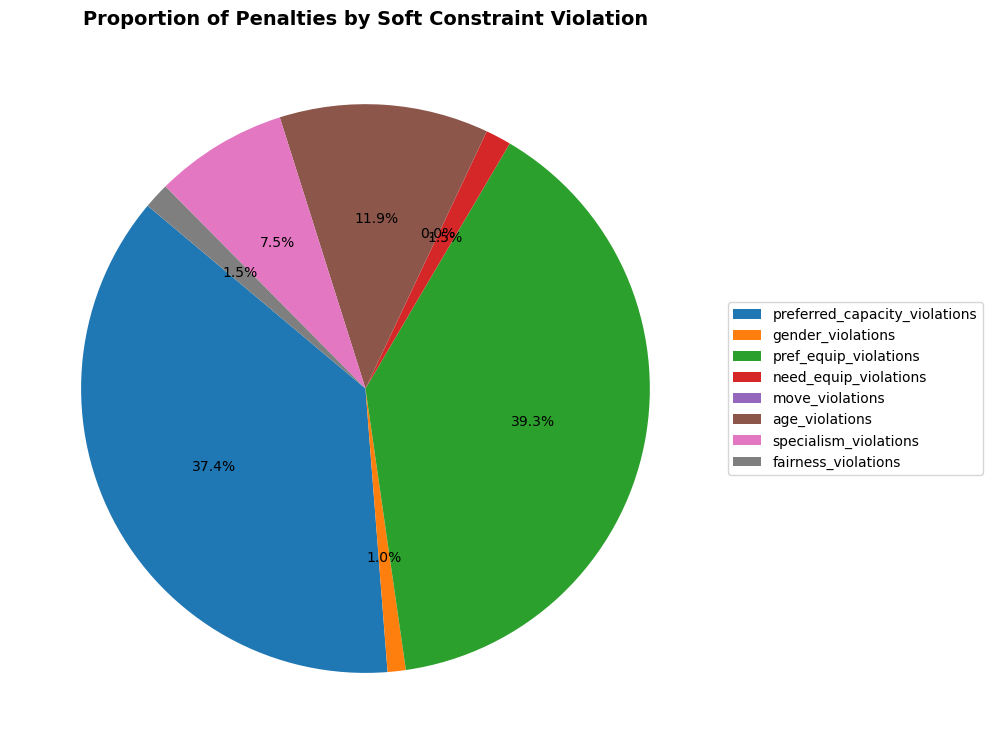

In [33]:
# Model 6, Historical Bias and FCFS with Uncertainty
# Main function to solve the hospital allocation problem
def solve_hospital_allocation():
    # 1) Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data() # Loads room and patient data
    random.seed(42) # Set random seed for reproducibility
    # Parse age limits for each department from a file
    department_age_limits = parse_department_ages("test9.txt") # Parses age constraints from a file

    # Metrics bookkeeping - Initialize variables to track performance and fairness
    total_duration = 0.0 # Total time taken to solve all days
    historical_penalties = {p.id: 0 for p in patients} # Dictionary to store cumulative penalties for each patient
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for the current day's assignments

    # 2) Horizon: days 0 … last admission day - Determine the range of days to consider
    last_admission_day = max(p.admission_day for p in patients) # Find the latest admission day among all patients
    all_days = range(last_admission_day + 1) # Create a range of all days from 0 up to the last admission day
    logs = {} # Dictionary for logging information (currently not used)
    all_assignments = {} # Dictionary to store assignment results for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation - Iterate through each day
    for current_day in all_days:
        print(f"Solving day {current_day}...") # Print the current day being solved
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {}) # Get penalties from the previous day
        max_prev_penalty = max(prev_penalties.values(), default=None) # Find the maximum penalty from the previous day

        # Simulate possible patient schedule changes ON THIS DAY - Introduce uncertainty in patient schedules
        for p in patients:

            # Delay admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of delay
                    delay = random.randint(1, 2) # Delay by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate original stay duration
                    p.admission_day += delay # Update admission day
                    p.release_day = p.admission_day + duration # Update release day

                    if not hasattr(p, "arrival_delays"): # Initialize list if it doesn't exist
                        p.arrival_delays = []
                    # Log the delay event
                    p.arrival_delays.append({
                        "day": current_day,
                        "delay": delay,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Early admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of early admission
                    advance = random.randint(1, 2) # Advance by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate original stay duration
                    p.admission_day = max(0, p.admission_day - advance) # Update admission day (ensure it's not negative)
                    p.release_day = p.admission_day + duration # Update release day

                    if not hasattr(p, "early_arrivals"): # Initialize list if it doesn't exist
                        p.early_arrivals = []
                    # Log the early arrival event
                    p.early_arrivals.append({
                        "day": current_day,
                        "advance": advance,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Late release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of late release
                    extension = random.randint(1, 2) # Extend by 1 or 2 days
                    p.release_day += extension # Update release day

                    if not hasattr(p, "late_releases"): # Initialize list if it doesn't exist
                        p.late_releases = []
                    # Log the late release event
                    p.late_releases.append({
                        "day": current_day,
                        "extension": extension,
                        "new_release": p.release_day,
                    })

            # Early release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of early release
                    reduction = random.randint(1, 2) # Reduce by 1 or 2 days
                    new_release = max(p.admission_day + 1, p.release_day - reduction) # Calculate new release day (ensure stay is at least 1 day)
                    if new_release < p.release_day: # Only log if release day actually changed
                        if not hasattr(p, "early_releases"): # Initialize list if it doesn't exist
                            p.early_releases = []
                        # Log the early release event
                        p.early_releases.append({
                            "day": current_day,
                            "early_by": p.release_day - new_release,
                            "new_release": new_release,
                        })
                        p.release_day = new_release # Update release day

        # Identify patients present on the current day after potential schedule changes
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        if not present_patients: # If no patients are present, skip to the next day
            continue

        # Calculate fairness thresholds based on historical penalties or base penalties
        if current_day > 0:
            # For days after the first, calculate fairness scores considering historical penalties
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    # Calculate base penalty and apply bias based on historical penalty
                    base_pen = compatibility_penalty(p, r)
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1) # Avoid division by zero
                    fairness_score = base_pen * bias
                    all_fairness_scores.append(fairness_score)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_fairness_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else:
            # For the first day, calculate thresholds based on base penalties only
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r)
                    all_base_scores.append(base_pen)

            # Calculate percentiles for thresholding
            scores_array = np.array(all_base_scores)
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # 3) CP-SAT Model Definition
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to store boolean variables representing patient-room assignments
        # Create a boolean variable for each possible patient-room assignment on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # Constraints
        # Each patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Equipment requirement constraint (Hard Constraint)
        # Determine the maximum number of equipment types to consider
        num_equipment_types = min(
            max(len(r.has) for r in rooms),
            max(len(p.needs) for p in present_patients)
        )

        # Enforce equipment need constraint for each equipment type
        for i in range(num_equipment_types):
            # Identify rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count of rooms with the equipment

            # Identify patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count of patients who need the equipment

            # Only enforce hard constraint if availability is greater than or equal to demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Ensure that a patient needing this equipment is assigned to a room that has it
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    model.AddBoolOr(assign_with_eq)


        # Soft Constraint Violations - Lists to store boolean variables for each type of violation
        viol_pref_cap = [] # Violations of preferred room capacity
        viol_gender = [] # Violations of gender preference
        viol_pref_eq = [] # Violations of preferred equipment
        viol_need_eq = [] # Violations of needed equipment (when not a hard constraint)
        viol_age = [] # Violations of department age limits
        viol_spec_minor = [] # Minor specialism mismatches (penalty 2)
        viol_spec_major = [] # Major specialism mismatches (penalty >= 3)
        viol_spec_mismatch = [] # Specialism not supported by the room
        viol_fairness_low = [] # Fairness violations below the low threshold
        viol_fairness_medium = [] # Fairness violations between low and high thresholds
        viol_fairness_high = [] # Fairness violations above the high threshold
        move_penalties = [] # Penalties for moving a patient to a different room
        viol_fcfs = [] # Violations of First-Come, First-Served (FCFS) principle


        # Populate the violation lists based on potential assignments
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the patient's previous room assignment
            for r in rooms:
                s = seats[(r.id, p.id)] # The boolean variable for this patient-room assignment

                # Check for FCFS violation (new patient getting a better room than previous day's max penalty)
                if max_prev_penalty is not None and p.admission_day == current_day:
                    # Patient is newly admitted
                    pen = compatibility_penalty(p, r)
                    if pen < max_prev_penalty:
                        # New patient got better room than existing patients had yesterday
                        viol_fcfs.append(s)

                # Check for each type of soft constraint violation if this assignment is made
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s)
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s)
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s)

                equip_need_len = min(len(p.needs), len(r.has))
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s)
                # --- Generalized Age Constraint --- Check age limits based on department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s)

                # --- Specialism 1 --- Check penalty for the first specialism
                if p.specialism_id1 in r.spec_ids:
                    idx = r.spec_ids.index(p.specialism_id1)
                    pen = r.penalties[idx]
                    if pen == 2:
                        viol_spec_minor.append(s)
                    elif pen >= 3:
                        viol_spec_major.append(s)
                else:
                    viol_spec_mismatch.append(s)

                # --- Specialism 2 --- Check penalty for the second specialism if it exists
                if p.specialism_id2 is not None:
                    if p.specialism_id2 in r.spec_ids:
                        idx = r.spec_ids.index(p.specialism_id2)
                        pen = r.penalties[idx]
                        if pen == 2:
                            viol_spec_minor.append(s)
                        elif pen >= 3:
                            viol_spec_major.append(s)
                    else:
                        viol_spec_mismatch.append(s)

                # Calculate fairness score with historical penalty bias
                base_pen = compatibility_penalty(p, r)
                if current_day > 0:
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias
                else:
                    fairness_score = base_pen

                # Check for fairness violations based on calculated thresholds
                if fairness_score > threshold_high:
                    viol_fairness_high.append(s)
                elif fairness_score > threshold_low:
                    viol_fairness_medium.append(s)
                elif fairness_score < threshold_low:
                    viol_fairness_low.append(s)
                # --- Move Penalty --- Add penalty if the patient is moved to a different room
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s)

        # Total number of patient-seat pairs (for normalization) - Used to scale the objective function
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools - Helper function for scaling sums of boolean variables
        def normalized_sum(viol_list):
            return sum(viol_list) * (1.0 / normalizer)

        # Weights - Define weights for each type of soft constraint violation
        Wcap, Wgen, Wpeq, Wneq, Wage = 3, 5, 3, 10, 7
        Wspec_minor, Wspec_major, Wspec_mismatch = 2, 6, 8
        Wfair_low, Wfair_med, Wfair_high = 1, 3, 9
        Wmove, Wfcfs = 10, 6 # Added weight for FCFS violations

        # Minimize scaled and weighted sum - Define the objective function to minimize total weighted violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap)
            + Wgen * normalized_sum(viol_gender)
            + Wpeq * normalized_sum(viol_pref_eq)
            + Wneq * normalized_sum(viol_need_eq)
            + Wage * normalized_sum(viol_age)
            + Wspec_minor * normalized_sum(viol_spec_minor)
            + Wspec_major * normalized_sum(viol_spec_major)
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch)
            + Wfair_low * normalized_sum(viol_fairness_low)
            + Wfair_med * normalized_sum(viol_fairness_medium)
            + Wfair_high * normalized_sum(viol_fairness_high)
            + Wmove * normalized_sum(move_penalties)
            + Wfcfs * normalized_sum(viol_fcfs) # Added FCFS violation term to the objective
        )

        # 4) Solve the model for the current day
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the defined model
        day_duration = time.time() - start # Calculate the time taken to solve the day
        total_duration += day_duration # Add the day's duration to the total duration

        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}") # Print solving status and time

        # 5) Process results if a solution is found
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the assigned room for each patient
            violation_scores = [] # List to store detailed violation scores for each patient-assignment
            daily_score = 0 # Total penalty score for the current day

            # Iterate through present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true
                        assigned_room = r # Assign the room
                        assign[p.id] = r.id # Store the assignment
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient
                        break # Move to the next patient once the room is found

                # If a room was assigned, calculate its penalty and update historical penalties
                if assigned_room:
                    pen = compatibility_penalty(p, assigned_room) # Calculate the compatibility penalty
                    daily_score += pen # Add to the daily total score
                    historical_penalties[p.id] += pen  # Update cumulative historical penalties

                    # Example equipment labels (update this list to match your dataset's actual columns and order)
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']  # Ensure this matches the actual dataset

                    # Only consider the minimum length to avoid IndexError in cases of inconsistent data
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find missing equipment indices
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine effective lengths for equipment lists for violation checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations --- Count specialism violation types
                    spec_minor = 0
                    spec_major = 0
                    spec_mismatch = 0

                    # Specialism 1
                    if p.specialism_id1 in assigned_room.spec_ids:
                        idx = assigned_room.spec_ids.index(p.specialism_id1)
                        spec_pen = assigned_room.penalties[idx]
                        if spec_pen == 2:
                            spec_minor += 1
                        elif spec_pen >= 3:
                            spec_major += 1
                    else:
                        spec_mismatch += 1

                    # Specialism 2
                    if p.specialism_id2 is not None:
                        if p.specialism_id2 in assigned_room.spec_ids:
                            idx = assigned_room.spec_ids.index(p.specialism_id2)
                            spec_pen = assigned_room.penalties[idx]
                            if spec_pen == 2:
                                spec_minor += 1
                            elif spec_pen >= 3:
                                spec_major += 1
                        else:
                            spec_mismatch += 1

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen,
                        'historical_penalty': historical_penalties[p.id],
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if needed equipment is missing (and not a hard constraint violation), 0 otherwise
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)),  # 1 if age limit violated, 0 otherwise (Update if using dynamic department age limits)
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatches
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id)) # 1 if patient was moved, 0 otherwise
                        }
                    })

                # Save results
                all_assignments[current_day] = {
                    'assignments': assign, # Assigned room for each patient
                    'violation_scores': violation_scores # Detailed violation scores
                }

                # Violation Counters (dynamic for equipment length)
                move_count = sum(v['violations']['moved'] for v in violation_scores) # Count of patients who were moved


            # Store the assignments and violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # Current day
                'num_patients': len(present_patients), # Number of patients present
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores), # Total preferred capacity violations
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores), # Total gender violations
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores), # Total preferred equipment violations
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores), # Total needed equipment violations
                'age_violations': sum(v['violations']['age'] for v in violation_scores), # Total age violations
                'specialism_violations': sum( # Total specialism violations (sum of minor, major, mismatch)
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                'fairness_violations': sum(1 for v in violation_scores if v['total_score']  > threshold_low), # Total fairness violations (total score > low threshold)
                'total_violation_score': daily_score, # Total daily penalty score
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # 6) Final metrics and reporting - Calculate overall statistics and generate reports
    if results: # Proceed only if there are results
        df = pd.DataFrame(results) # Convert results list to a pandas DataFrame
        total_days = len(all_days) # Total number of days in the planning horizon
        success_rate = len(results) / total_days * 100 # Percentage of days successfully solved
        patient_ids = list(historical_penalties.keys()) # List of all patient IDs
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        penalty_vals = list(avg_daily_penalty.values()) # List of average daily penalty values

        # Calculate fairness metrics (Standard Deviation, Gini, Jain)
        std_dev = np.std(penalty_vals)
        gini = compute_gini(penalty_vals)
        jain = compute_jain(penalty_vals)

        # Calculate average penalties for all patients and find min/max
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        max_penalty_idx = np.argmax(penalty_vals) # Index of patient with maximum average daily penalty
        min_penalty_idx = np.argmin(penalty_vals) # Index of patient with minimum average daily penalty

        total_fairness_penalties = df['fairness_violations'].sum() # Calculate the total fairness violations across all days
        print(f"Total Fairness Penalties: {total_fairness_penalties}") # Print total fairness penalties

        # Build summary stats - Create a dictionary for the summary statistics table
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)",
                "Success Rate (%)",
                "Fairness - StdDev of Daily Penalty",
                "Fairness - Gini Coefficient",
                "Fairness - Jain Index",
                "Total Penalty - Mean",
                "Total Penalty - StdDev",
                "Total Penalty - Min",
                "Total Penalty - Max",
                "Avg Daily Penalty - Mean",
                "Avg Daily Penalty - StdDev",
                "Avg Daily Penalty - Min",
                "Avg Daily Penalty - Max",
                "Patients with Zero Penalty",
                "Patients with High Penalty (>mean+std)",
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})",
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})",
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total solving time
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of patients with high penalty
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Details for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Details for least penalized patient
            ]
        }

        # Create a DataFrame for the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False))
        # Save summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics9.csv", index=False)
        # Save summary statistics as a PNG image (table format)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        table = ax.table(cellText=summary_df.values, # Create table from DataFrame values
                         colLabels=summary_df.columns, # Use DataFrame columns as column labels
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table in the axes
        table.auto_set_font_size(False) # Disable automatic font sizing
        table.set_fontsize(10) # Set font size for table text
        table.scale(1, 1.2) # Scale the table size
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Add a title
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.savefig("hospital_summary_statistics9.png", dpi=300) # Save the table as a PNG image
        plt.close() # Close the plot

        # Plots - Generate various plots to visualize results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a 2x2 grid of subplots

        # 1. Total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar chart
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-axis label
        axes[0,0].set_ylabel('Total Penalty') # Set y-axis label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability

        # 2. Average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar chart
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-axis label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-axis label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-axis label
        axes[1,0].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-axis label
        axes[1,1].set_ylabel('Number of Patients') # Set y-axis label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary9.png") # Save the subplots as a PNG image
        plt.show() # Display the plots

        # Additional detailed penalty analysis
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing penalty distribution
        plt.subplot(2, 1, 1) # Create a subplot (2 rows, 1 column, 1st plot)
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-axis label

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary3.png") # Save the box plot as a PNG image
        plt.show() # Display the plot

        # Constraint Violations Over Time (Stacked Bar Chart)
        violation_cols = [ # List of columns representing different violation types
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations', 'fairness_violations'
        ]

        # Plot stacked bar chart of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Number of Violations") # Set y-axis label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time9.png") # Save the plot as a PNG image
        plt.show() # Display the plot

        # Proportion of Penalties by Soft Constraint Violation (Pie Chart)
        # Sum total violations for each type
        violation_totals = df[violation_cols].sum() # Calculate the sum of each violation type across all days

        plt.figure(figsize=(10, 10)) # Create a new figure
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels directly on slices
            autopct='%1.1f%%', # Format for percentage display
            startangle=140 # Starting angle for the first slice
        )
        # Add a legend with violation types and percentages
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold') # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart9.png", dpi=300) # Save the pie chart as a PNG image
        plt.show() # Display the plot

    # Return the results
    return all_assignments, rooms, patients, results

# Main execution block
if __name__ == "__main__":
    # Solve the hospital allocation problem
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark
        filename="hospital_assignment_report9.pdf" # Output filename for the PDF
    )

In [37]:
# Function to plot penalty distributions and total/average penalties for a given day
def plot_day_penalties(day, all_assignments, patients):
    # Check if data exists for the given day
    if day not in all_assignments:
        print(f"No data available for Day {day}.") # Print message if no data is found
        return

    os.makedirs("plots", exist_ok=True) # Create a 'plots' directory if it doesn't exist

    assignments = all_assignments[day]['assignments'] # Get room assignments for the day
    violations = all_assignments[day]['violation_scores'] # Get violation scores for the day

    day_patient_ids = list(assignments.keys()) # Get the IDs of patients present on this day
    penalty_vals = [] # List to store total penalty values for each patient
    avg_penalties = [] # List to store average daily penalty values for each patient

    # Calculate the length of stay for each patient
    stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}

    # Calculate total and average daily penalties for each patient present on the day
    for pid in day_patient_ids:
        total_penalty = sum(
            entry['total_score']
            for entry in violations
            if entry['patient_id'] == pid
        )
        stay = stay_length.get(pid, 1) # Get stay length, default to 1 if not found
        penalty_vals.append(total_penalty) # Append total penalty
        avg_penalties.append(total_penalty / stay) # Append average daily penalty

    # Create a figure and a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Bar chart of Total Penalties by Patient ID
    axes[0,0].bar(day_patient_ids, penalty_vals)
    axes[0,0].set_title(f'Total Penalties (Day {day})')
    axes[0,0].set_xlabel('Patient ID')
    axes[0,0].set_ylabel('Total Penalty')
    axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels

    # Plot 2: Bar chart of Average Daily Penalties by Patient ID
    axes[0,1].bar(day_patient_ids, avg_penalties)
    axes[0,1].set_title(f'Average Daily Penalties (Day {day})')
    axes[0,1].set_xlabel('Patient ID')
    axes[0,1].set_ylabel('Average Daily Penalty')
    axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

    # Plot 3: Histogram of Total Penalties Distribution
    axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black')
    axes[1,0].set_title(f'Distribution of Total Penalties (Day {day})')
    axes[1,0].set_xlabel('Total Penalty')
    axes[1,0].set_ylabel('Number of Patients')
    # Add mean and median lines to the histogram
    axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}')
    axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}')
    axes[1,0].legend() # Add legend

    # Plot 4: Histogram of Average Daily Penalties Distribution
    axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black')
    axes[1,1].set_title(f'Distribution of Avg Daily Penalties (Day {day})')
    axes[1,1].set_xlabel('Avg Daily Penalty')
    axes[1,1].set_ylabel('Number of Patients')
    # Add mean and median lines to the histogram
    axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}')
    axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}')
    axes[1,1].legend() # Add legend

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.savefig("daily_violations3.png") # Save the figure
    plt.show() # Display the figure

# Function to plot the room assignment timeline for a specific patient
def plot_patient_timeline(patient_id, all_assignments):
    timeline_data = [] # List to store room assignment data for the patient over time
    # Iterate through assignments for each day
    for d, data in all_assignments.items():
        assignment = data['assignments'] # Get assignments for the current day
        if patient_id in assignment: # Check if the patient was present and assigned on this day
            timeline_data.append({
                'day': d, # Day
                'room_id': assignment[patient_id] # Assigned room ID
            })

    # Create a pandas DataFrame from the timeline data and sort by day
    df_patient = pd.DataFrame(timeline_data).sort_values(by='day')
    if not df_patient.empty: # Proceed only if the DataFrame is not empty
        # Create a DataFrame with all days the patient was present to ensure a continuous timeline
        full_days = pd.DataFrame({'day': range(df_patient['day'].min(), df_patient['day'].max() + 1)})
        # Merge with the actual assignment data, filling missing days with the last known room (forward fill)
        df_patient = pd.merge(full_days, df_patient, on='day', how='left')
        df_patient['room_id'].ffill(inplace=True) # Forward fill missing room assignments

        plt.figure(figsize=(10, 4)) # Create a new figure for the timeline plot
        # Create a step plot showing room changes over time
        plt.step(df_patient['day'], df_patient['room_id'], where='mid', linewidth=2)
        # Add markers for each day the patient was assigned
        plt.scatter(df_patient['day'], df_patient['room_id'], color='blue', s=30)

        plt.xlabel("Day") # Set x-axis label
        plt.ylabel("Room ID") # Set y-axis label
        plt.title(f"Room Assignment Timeline for Patient {patient_id}") # Set title
        # Set y-axis ticks to show unique room IDs the patient was in
        plt.yticks(sorted(df_patient['room_id'].unique()))
        plt.xticks(df_patient['day']) # Set x-axis ticks to show days
        plt.grid(True) # Add a grid
        plt.tight_layout() # Adjust layout
        plt.savefig("patient_violations9.png") # Save the figure
        plt.show() # Display the figure

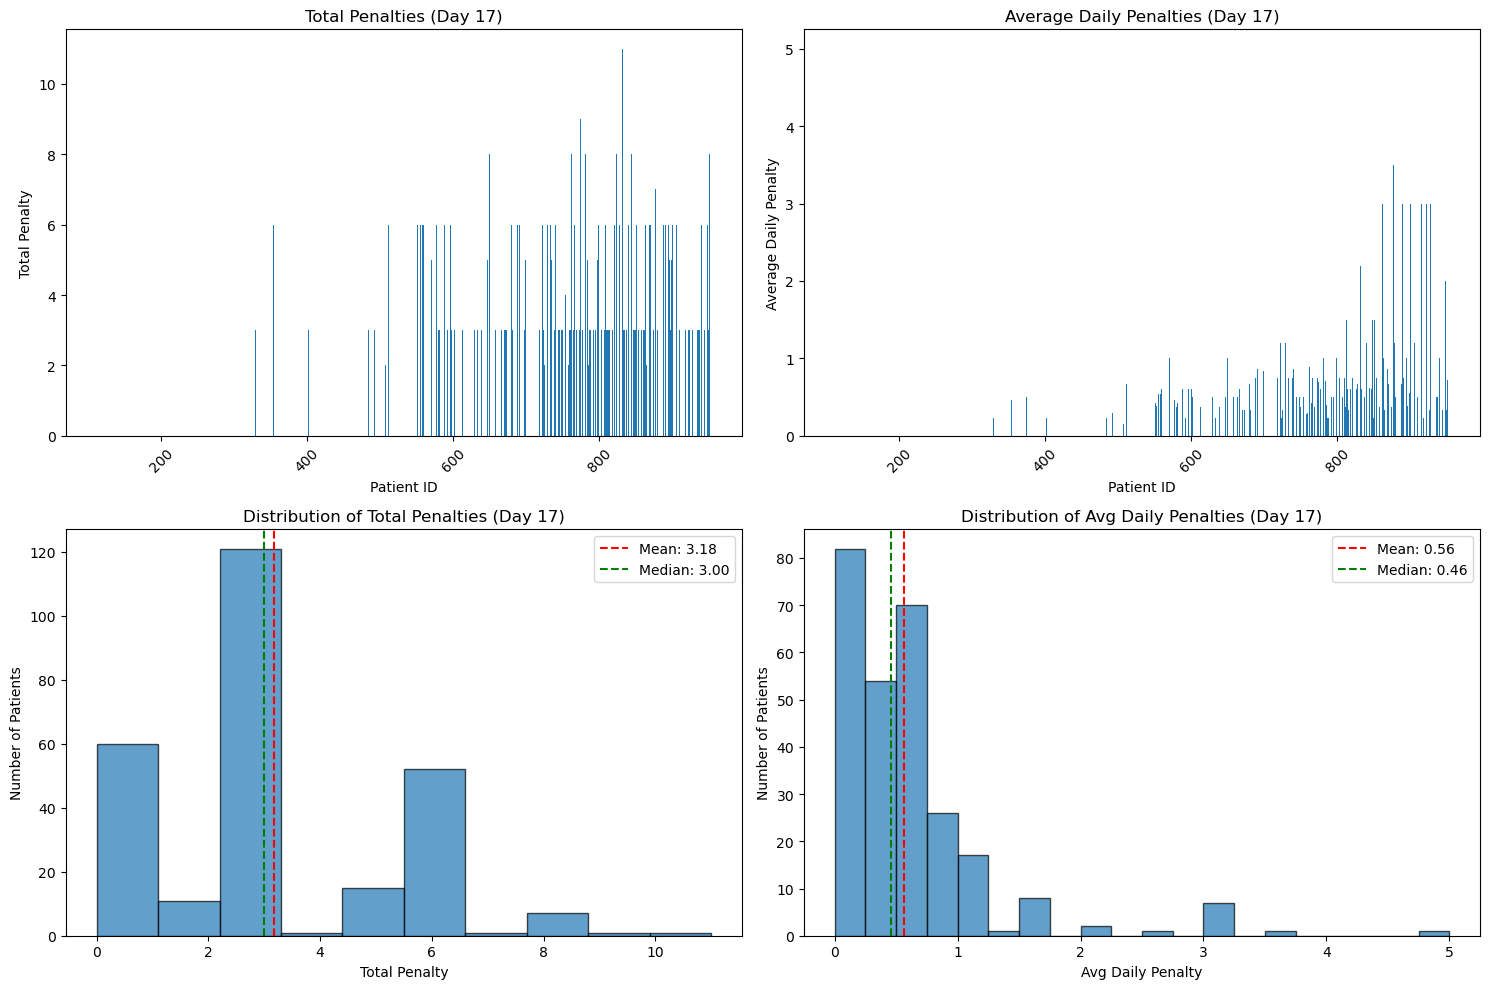

In [39]:
# Plot penalty distributions for a specific day 
plot_day_penalties(day=17, all_assignments=all_assignments, patients=patients)

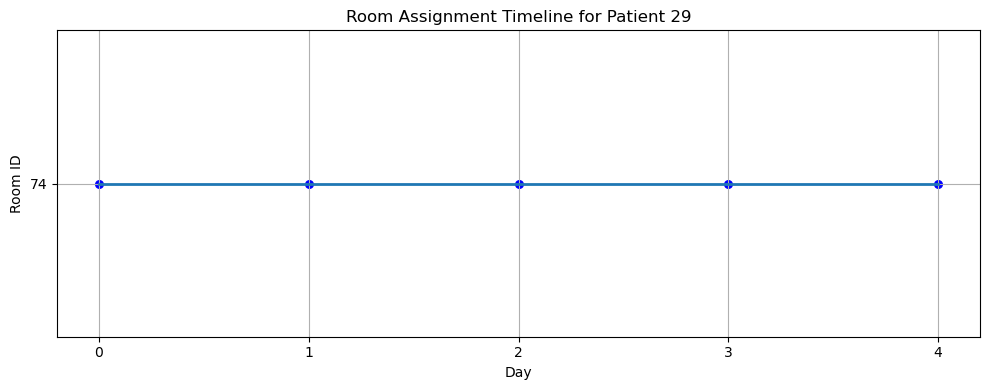

In [41]:
# Plot the room timeline for a specific patient 
plot_patient_timeline(patient_id=29, all_assignments=all_assignments)